<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/1IMRxByfg7gjoZ5i7rxvuNDvSrbdOJOc-/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

In [ ]:
# !pip install -q transformers
# https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/
!pip install -q transformers[torch]
!pip install -q accelerate -U
!pip install -q datasets
!pip install -q evaluate

In [ ]:
import requests
import pandas as pd
import transformers
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, BertModel
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, BertModel
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
from transformers import AutoConfig, AutoTokenizer, AutoModel
from datasets import Dataset
from torch.nn.utils.rnn import pad_sequence
import seaborn as sns
import copy
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from transformers import get_cosine_schedule_with_warmup

from IPython.display import clear_output

2024-04-14 16:18:12.956556: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 16:18:12.956678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 16:18:13.108559: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive/')
# SAVE_PATH='/content/gdrive/MyDrive/dls_2-4/'

Mounted at /content/gdrive/


# Получение файла и препроцессинг

In [ ]:
# URL файла
url = 'https://docs.google.com/spreadsheets/d/1IMRxByfg7gjoZ5i7rxvuNDvSrbdOJOc-/edit#gid=2091824646'

# Получение ID файла из URL
file_id = url.split('/')[-2]

# Создание прямой ссылки на скачивание файла
dwn_url = 'https://drive.google.com/uc?id=' + file_id

# Скачивание файла
response = requests.get(dwn_url)

# Сохранение файла локально
with open('data.xlsx', 'wb') as f:
    f.write(response.content)

# Чтение файла с помощью pandas
df = pd.read_excel('data.xlsx')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.rename(columns={'Задача': 'text', 'Тема':'labels'}, inplace=True)
df.head()

text labels
0  Между девятью планетами Солнечной системы введ...  Графы
1  В стране Цифра есть 9 городов с названиями 1, ...  Графы
2  В государстве 100 городов, и из каждого из них...  Графы
3  В классе 30 человек. Может ли быть так, что 9 ...  Графы
4  В городе Маленьком 15 телефонов. Можно ли их с...  Графы

In [ ]:
df.labels.unique()

array(['Графы', 'Геометрия', 'Многочлен', 'Комбинаторика', 'Теория чисел',
       'Инвариант', 'Дирихле'], dtype=object)

In [ ]:
change_dict={'Графы':'graph',
             'Геометрия':'geometry',
             'Многочлен': 'polynom',
             'Комбинаторика': 'combinatorics',
             'Теория чисел': 'number_theory',
             'Инвариант': 'invariant',
             'Дирихле': 'dirichlet'
}
df.replace({"labels": change_dict}, inplace=True)

LABEL_COLUMNS = ['graph','geometry','polynom','combinatorics','number_theory','invariant','dirichlet']

известно (хех), что в данных есть загрязнение: после слов "прислать комментарии" идет текст, не относящийся к метке. Удалим его. Кроме того, уберем пробелы в начале и в конце текста, перенос строки и табуляции.

In [ ]:
df['text'] = df['text'].str.split('Прислать комментарий').str[0].str.strip()
# Замена всех табуляций и символов переноса строки на пробелы
df['text'] = df['text'].str.replace('\t', ' ').str.replace('\n', ' ')
# Замена всех двух и более пробелов на один пробел
df['text'] = df['text'].str.replace(r'\s{2,}', ' ', regex=True)
# кодируем метки классов
# le = LabelEncoder()
# df['labels'] = le.fit_transform(df['labels'])

проверим совместную встречаемость меток задач

In [ ]:
df['val']=1
df=df[df['text']!='']
res = pd.pivot_table(df, index='text', columns='labels', aggfunc="sum", fill_value=0)
res=res['val']
res.T.dot(res)

labels         combinatorics  dirichlet  geometry  graph  invariant  \
labels                                                                
combinatorics           1028         78         0    378         20   
dirichlet                 78        432         2     43          3   
geometry                   0          2       293      0          0   
graph                    378         43         0    378          3   
invariant                 20          3         0      3        232   
number_theory            205        106         0     99         96   
polynom                   33          3         1      2          5   

labels         number_theory  polynom  
labels                                 
combinatorics            205       33  
dirichlet                106        3  
geometry                   0        1  
graph                     99        2  
invariant                 96        5  
number_theory           2395       57  
polynom                   57      448

Судя по всему так и задумано, одна и та же задача может быть отнесена к разным классам. Значит необходима multiclass multilabel классификация. Видно, что все задачи на графы (их 378) отнесены и к задачам комбинаторики. А так же некоторые из них - к теории чисел, дирихле и т.д.

In [ ]:
df = res.reset_index()

In [ ]:
df_en=pd.read_excel('/kaggle/input/dls-2-4-mathdata-en/math_data_en.xlsx')
df_en.head()
# переведенные на английский тексты зада нам понадобятся позднее

text   combinatorics  \
0   A “crocodile” is a figure whose move consists...               0   
1   “corner” is a figure made up of three squares...               0   
2   (a1, ..., an, b1, ..., bn are different numbe...               0   
3   (k, j, i) ↔ (k – 1, j + 1, i), (k, j, i) ↔ (k...               1   
4  (Try to prove these identities in three differ...               1   

    dirichlet   geometry   graph   invariant   number_theory   polynom  
0           0          0       0           0               1         0  
1           0          0       0           0               1         0  
2           0          0       0           0               0         1  
3           0          0       0           0               0         0  
4           0          0       0           0               0         0

исправление некоторых артефактов перевода

In [ ]:
import re
import regex

df_en.columns = df.columns.str.replace("[^\w_]", "", regex=True)

# DATASET
сформируем универсальный датасет, который можно использовать и в самописном trainloop и huggingface

<Axes: ylabel='labels'>

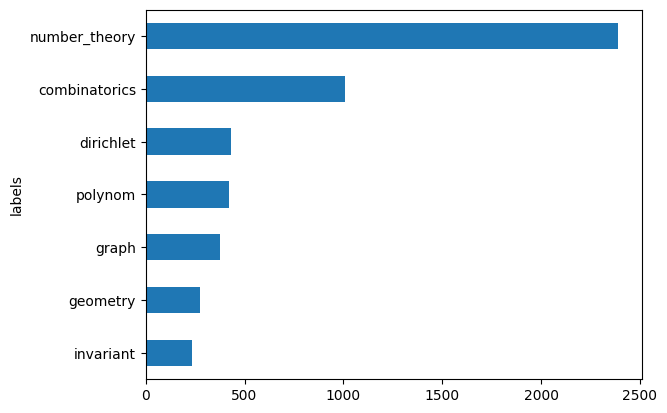

In [ ]:
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh")

In [ ]:
df

labels                                               text  combinatorics  \
0       "Крокодилом" называется фигура, ход которой за...              0   
1       "Уголком" называется фигура, составленная из т...              0   
2           (a1, ..., an, b1, ..., bn – различные числа.)              0   
3       (k, j, i) ↔ (k – 1, j + 1, i), (k, j, i) ↔ (k ...              1   
4       (Попробуйте доказать эти тождества тремя разны...              1   
...                                                   ...            ...   
4173               может быть записана в виде где = , = .              1   
4174    нужно провести, чтобы вычеркнуть все отмеченны...              0   
4175    причем коэффициенты ck могут быть найдены по ф...              0   
4176    – У меня зазвонил телефон. – Кто говорит? – Сл...              1   
4177    – разложение натурального числа m на простые м...              0   

labels  dirichlet  geometry  graph  invariant  number_theory  polynom  
0               0         0      0          0              1        0  
1               0         0      0          0              1        0  
2               0         0      0          0              0        1  
3               0         0      0          0              0        0  
4               0         0      0          0              0        0  
...           ...       ...    ...        ...            ...      ...  
4173            0         0      0          0              0        0  
4174            1         0      0          0              0        0  
4175            0         0      0          0              0        1  
4176            0         0      0          0              0        0  
4177            0         0      0          0              1        0  

[4178 rows x 8 columns]

In [ ]:
def preprocess_function(example, tokenizer, label_columns):

    tokenized_example = tokenizer(example["text"], padding=True, truncation=True, max_length=512, return_tensors='pt')
    label_tensor = torch.tensor([example[col] for col in label_columns], dtype=torch.float)
    res={
        'input_ids': tokenized_example['input_ids'].squeeze(0),
        'attention_mask': tokenized_example['attention_mask'].squeeze(0),
        'labels': label_tensor
    }
    return res

def make_ds(df, model_name, label_columns):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    ds=Dataset.from_pandas(df)
    ds = ds.with_format("torch")
    ds = ds.map(lambda examples: preprocess_function(examples, tokenizer, label_columns))
#     ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    return ds


In [ ]:
# ds = make_ds(df, model_name='cointegrated/rubert-tiny2', label_columns = LABEL_COLUMNS )

Map:   0%|          | 0/4178 [00:00<?, ? examples/s]

In [ ]:
def collate_fn(batch):
    """
    Функция для обработки батча данных, добавляя нулевой паддинг к тензорам input_ids и attention_mask.
    список тензоров labels превращает в тензор
    """
    input_ids = [item['input_ids'] for item in batch]

    attention_mask = [item['attention_mask'] for item in batch]
    labels=[item['labels'] for item in batch]
    # Добавление нулевого паддинга к input_ids и attention_mask
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    # labels = pad_sequence(labels, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

# Использование collate_fn в DataLoader
# dataloader = DataLoader(ds, batch_size=2, shuffle=True, collate_fn=collate_fn)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny2')
token_counts = []
for _, row in df.iterrows():
    token_count = len(tokenizer.encode(
    row["text"],
    max_length=512,
    truncation=False
  ))
    token_counts.append(token_count)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

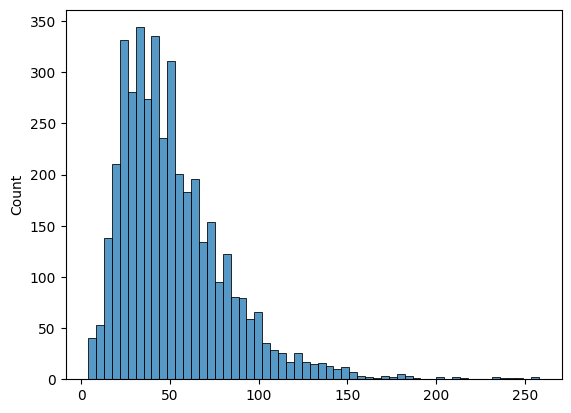

In [ ]:
sns.histplot(token_counts)

Большинство пердложений не превышают 250 токенов

#### вывод по датасету
в датасете содержались нерелевантные тексты, после слов "прислать комментарии"- их выкинули. Задачу можно решать как multiclass classification - тогда надо выкинуть "дубли", а можно - как multilabel. Поскольку ранее в курсе multilabel не встречался, мне было интереснее работать с задачей именно как multilabel.

mathBert обучен на английских текстах. Сложности с русским языком можно будет увидеть ниже. [Есть переведенный датасет](https://t.me/dls_spring2024_part2/682/6607), но там выкинуты "дубликаты", поэтому я предпочел просто перевести эксель-файл гуглом.

Кстати, есть и полный [датасет](https://www.kaggle.com/datasets/recursingfeynman/russian-math-problems-dataset/data), но я решил с ним не экспериментировать из-за ограничения по времени.

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [ ]:
class TransformerClassificationModel(nn.Module):
    def __init__(self, model_name, num_labels, return_full=True):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.backbone = AutoModel.from_pretrained(model_name, config=self.config)
        # self.non_lin=nn.ReLU() # в целом совсем не обязательно
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)
        self.return_full = return_full

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, inputs_embeds=None, labels=None, text=None):
# input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, inputs_embeds=None, labels=None, text=None
        outputs = self.backbone(

            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=True
        )
        sequence_output = outputs[0][:,0,:]
        logits = self.classifier(sequence_output)
        res={}
        res['logits']=logits
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss()
            loss = loss_fct(logits, labels)
            res['loss']=loss
        if self.return_full:
            res['full_output']=outputs
        return res


model=TransformerClassificationModel('cointegrated/rubert-tiny2', num_labels=7 )

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [ ]:
def freeze_backbone_function(model: TransformerClassificationModel):
    # Создаем новый экземпляр модели, чтобы не изменять оригинальную модель
    frozen_model = copy.deepcopy(model)
    # замораживаем все веса
    for param in frozen_model.parameters():
        param.requires_grad = False
    # Размораживаем параметры последнего линейного слоя
    for param in frozen_model.classifier.parameters():
        param.requires_grad = True
    return frozen_model

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

#### Рассчет метрики multilabel

In [ ]:
def compute_exact_match_ratio(preds, labels):
    """
    Функция для расчета Exact Match Ratio (EMR).
    :param preds: предсказанные значения
    :param labels: истинные значения
    :return: значение EMR
    """
    assert len(preds) == len(labels), "Predictions and labels must have the same length"

    exact_matches = sum(np.all(p == l) for p, l in zip(preds, labels))
    return exact_matches / labels.shape[0]

def compute_metrics(eval_preds):
    predictions, labels = eval_preds
    predictions = sigmoid(predictions) > 0.5
    emr = compute_exact_match_ratio(predictions, labels)
    # Предполагается, что compute_exact_match_ratio возвращает массив, поэтому используем np.mean()
    return {"exact_match_ratio": emr}

#### train_on_batch()

In [ ]:
def train_on_batch(model, batch, optimizer, device):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    model.train()
    model.zero_grad()
    input_ids=input_ids.to(device)
    attention_mask= attention_mask.to(device)
    labels = labels.to(device)
    result = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

    loss = result['loss']
    loss.backward()
    optimizer.step()
    # рассчет метрики exact_match - для образца совпадают ВСЕ метки

    preds=(torch.sigmoid(result['logits'])>0.5).detach().cpu().numpy()
    lbl = labels.detach().cpu().numpy()

    emr = compute_exact_match_ratio(preds, lbl)
    exact_match = torch.all(( torch.sigmoid(result['logits']) >0).float()==labels, dim=1).int().sum()
    correct_per_class = torch.sum((result['logits']>0).float() == labels, dim=0)
    total_samples = labels.shape[0]


    return loss.detach().item(), emr*total_samples, total_samples, correct_per_class

def val_on_batch(model, batch, device):
    model.eval()
    with torch.no_grad():
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        input_ids=input_ids.to(device)
        attention_mask= attention_mask.to(device)
        labels = labels.to(device)
        result = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = result['loss']
        preds=(torch.sigmoid(result['logits'])>0.5).detach().cpu().numpy()
        lbl = labels.detach().cpu().numpy()
        emr = compute_exact_match_ratio(preds, lbl)
        correct_per_class = torch.sum((result['logits']>0).float() == labels, dim=0)
        total_samples = labels.shape[0]

    return loss.detach().item(), emr*total_samples, total_samples, correct_per_class

#### train_epoch()

In [ ]:
def train_epoch(train_data_loader, model, optimizer, device):
    sum_loss = 0
    sum_exact_match = 0
    sum_total_samples = 0
    sum_correct_per_class=[]

    model.train()
    for batch in  train_data_loader: #  tqdm(train_data_loader): #  , leave=False
        batc_len=len( batch['labels'])
        loss_train_batch, exact_match, total_samples, correct_per_class =\
            train_on_batch(model=model,
                          batch=batch,
                          optimizer=optimizer,
                          device=device)

        sum_loss += loss_train_batch*batc_len
        sum_exact_match += exact_match
        sum_total_samples += batc_len
        sum_correct_per_class.append(correct_per_class)
    sum_correct_per_class=torch.sum(torch.stack(sum_correct_per_class), dim=0)

    return sum_loss/sum_total_samples, sum_exact_match/sum_total_samples, sum_correct_per_class/sum_total_samples

def val_epoch(model, val_data_loader, device):
    sum_loss = 0
    sum_exact_match = 0
    sum_total_samples = 0
    sum_correct_per_class=[]
    model.eval()
    for batch in val_data_loader: #  tqdm(val_data_loader, leave = False): #  tqdm(val_data_loader, leave = False):
        batc_len=len( batch['labels'])
        loss_val_batch, exact_match, total_samples, correct_per_class =\
            val_on_batch(model=model,
                          batch=batch,
                          device=device)

        sum_loss += loss_val_batch*batc_len
        sum_exact_match += exact_match
        sum_total_samples += batc_len
        sum_correct_per_class.append(correct_per_class)
    sum_correct_per_class=torch.sum(torch.stack(sum_correct_per_class), dim=0)

    return sum_loss/sum_total_samples, sum_exact_match/sum_total_samples, sum_correct_per_class/sum_total_samples

#### Визуализация

In [ ]:
def plot_history(history):
    LABEL_COLUMNS = ['graph','geometry','polynom','combinatorics','number_theory','invariant','dirichlet']
    # Проверяем, что все необходимые поля присутствуют в словаре
    required_fields = ['epoch', 'train_loss', 'val_loss', 'train_exact_match', 'val_exact_match', 'train_correct_per_class', 'val_correct_per_class']
    for field in required_fields:
        if field not in history:
            raise ValueError(f"Отсутствует поле {field} в словаре history")

    # Создаем фигуру и подграфики
    fig, axs = plt.subplots(2, 2, figsize=(15, 8))

    # Первый подграфик: train_loss и val_loss от epoch
    axs[0, 0].plot(history['epoch'], history['train_loss'], label='Train Loss')
    axs[0, 0].plot(history['epoch'], history['val_loss'], label='Validation Loss')
    axs[0, 0].set_title('Loss over Epochs')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    # Второй подграфик: train_exact_match и val_exact_match от epoch
    axs[0, 1].plot(history['epoch'], history['train_exact_match'], label='Train Exact Match')
    axs[0, 1].plot(history['epoch'], history['val_exact_match'], label='Validation Exact Match')
    axs[0, 1].set_title('Exact Match over Epochs')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Exact Match')
    axs[0, 1].legend()

    # Третий подграфик: зависимость каждого столбца train_correct_per_class от epoch
    for i, column in enumerate(np.array(history['train_correct_per_class']).T):
        axs[1, 0].plot(history['epoch'], column, label=f'Class {LABEL_COLUMNS[i]}')
    axs[1, 0].set_title('Train Correct Per Class over Epochs')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Correct Per Class')
    axs[1, 0].legend()

    # Четвертый подграфик: зависимость каждого столбца val_correct_per_class от epoch
    for i, column in enumerate(np.array(history['val_correct_per_class']).T):
        axs[1, 1].plot(history['epoch'], column, label=f'Class {LABEL_COLUMNS[i]}')
    axs[1, 1].set_title('Validation Correct Per Class over Epochs')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Correct Per Class')
    axs[1, 1].legend()

    # Показываем графики
    plt.tight_layout()
    plt.show()

### train_transformer()  - собственно, функция тренировки

In [ ]:
def train_transformer(transformer_model,
                      epochs,
                      train_data_loader,
                      val_data_loader,
                      experiment_name,
                      device,
                      freeze_backbone=True,
                      save_path='/kaggle/working/',
                      start_from_chp=False,
                      lr=3e-4,
                      scheduler=None):
    model = copy.deepcopy(transformer_model)
    model.to(device)
    history=None
    # если хотим стартовать из чекпойнта, то по пути сохранения и имени модели копируем с диска, грузим в память, грузим в модель
    if start_from_chp:
        checkpoint=torch.load(save_path+experiment_name+'.chp')
        history = checkpoint['history']
        best_model_sate_dict = checkpoint['model']
        best_optimizer_state_dict = checkpoint['optimizer']
        best_scheduler_state_dict = checkpoint['scheduler']

        model.load_state_dict(best_model_sate_dict)
        optimizer.load_state_dict(best_optimizer_state_dict)
        if best_scheduler_state_dict is not None:
            scheduler.load_state_dict(best_scheduler_state_dict)
        min_val_perplexity = min(history['val_perplexity'])
        start_epoch=max(history['epoch'])+1
    else:
        history={'epoch':[],
                 'train_loss':[], 'train_exact_match':[],
                 'train_correct_per_class':[],
                 'val_loss':[], 'val_exact_match':[],
                 'val_correct_per_class':[]
                 }
        start_epoch=1
        min_val_exact_match = 0.
    if freeze_backbone:
        model = freeze_backbone_function(model)

    # А вот теперь создаем оптимайзер! у нас до этого модель 2 !!! раза скопировалась (или один, если не морозили bacbone)
    optimizer=torch.optim.AdamW(model.parameters(), lr=lr)

    if scheduler == 'get_cosine_schedule_with_warmup':
        num_warmup_steps = int(epochs*0.1)
        num_training_steps = int(epochs)
        num_cycles = 0.5
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=num_warmup_steps,
            num_training_steps=num_training_steps,
            num_cycles=num_cycles
        )


    for it in range(epochs): #iterations:
        model.train()
        # train_data_loader, model, loss_function, optimizer, device, labels_to_control=0
        train_loss, train_exact_match, train_correct_per_class =\
            train_epoch(train_data_loader=train_data_loader,
                        model=model,
                        optimizer=optimizer,
                        device=device,)

        history['epoch'].append(it + start_epoch)
        history['train_loss'].append(train_loss)  # .cpu().numpy())
        history['train_exact_match'].append(train_exact_match ) #.cpu().detach().numpy()
        history['train_correct_per_class'].append(train_correct_per_class.cpu().detach().numpy())
        print( 'train done')
        model.eval()
        with torch.no_grad():
            val_loss, val_exact_match, val_correct_per_class =\
            val_epoch(val_data_loader=val_data_loader,
                        model=model,
                        device=device,)

            history['val_loss'].append(val_loss)  # .cpu().numpy())
            history['val_exact_match'].append(val_exact_match ) #.cpu().detach().numpy()
            history['val_correct_per_class'].append(val_correct_per_class.cpu().detach().numpy())

        if scheduler is not None:
            scheduler.step()

        # сохраняем историю. если метрика меньше минимальной на истории - созраняем веса модели

        # checkpoint = {'history': history}
        # torch.save(history, save_path+experiment_name+'_history.chp')
        # сохраняем последний чекпойнт, практика показывает, что мы не успеваем дойти до переобучения
        if scheduler is not None:
            scheduler_state_dict = scheduler.state_dict()
        else:
            scheduler_state_dict = None
        checkpoint = {'history': history,
                        'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler_state_dict}
        torch.save(checkpoint, experiment_name+'.chp')

        clear_output(wait=True)
        print(it)
        plot_history(history)
        # print(history)

    return model

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [ ]:
ds = make_ds(df, model_name='cointegrated/rubert-tiny2', label_columns = LABEL_COLUMNS )
ds_s=ds.train_test_split(test_size=0.2)
train_dataloader = DataLoader(ds_s['train'], batch_size=16, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(ds_s['test'], batch_size=16, shuffle=False, collate_fn=collate_fn)

Map:   0%|          | 0/4178 [00:00<?, ? examples/s]

49


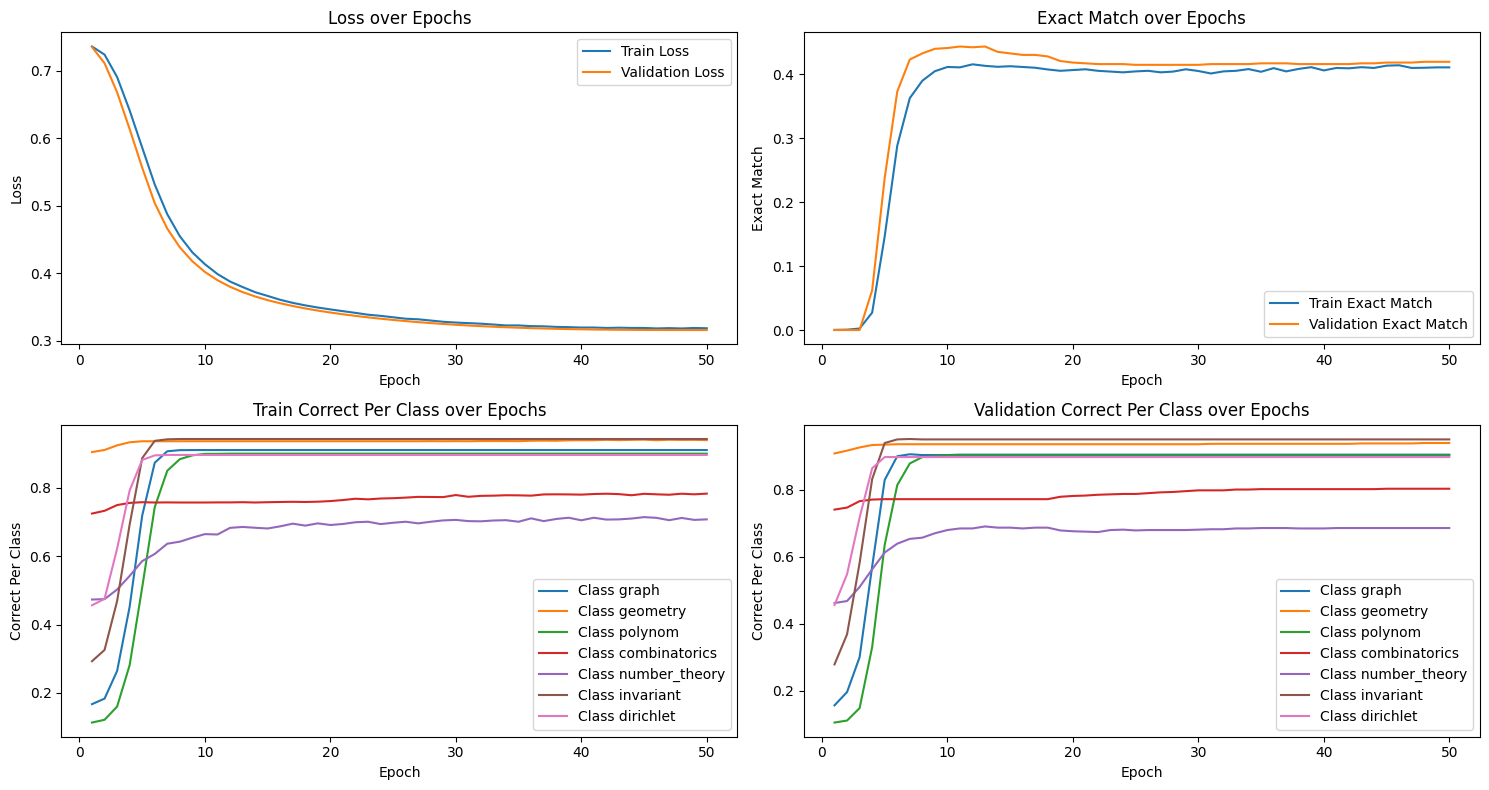

In [ ]:
rubert_tiny_transformer_model = TransformerClassificationModel('cointegrated/rubert-tiny2', num_labels=7 )
rubert_tiny_freezed = train_transformer(transformer_model=rubert_tiny_transformer_model,
                      epochs=50,
                      train_data_loader=train_dataloader,
                      val_data_loader=test_dataloader,
                      experiment_name= 'rubert_tiny_freezed',
                      device=device,
                      freeze_backbone=True,
                      start_from_chp=False,
                      lr=2e-5,
                      scheduler='get_cosine_schedule_with_warmup')

49


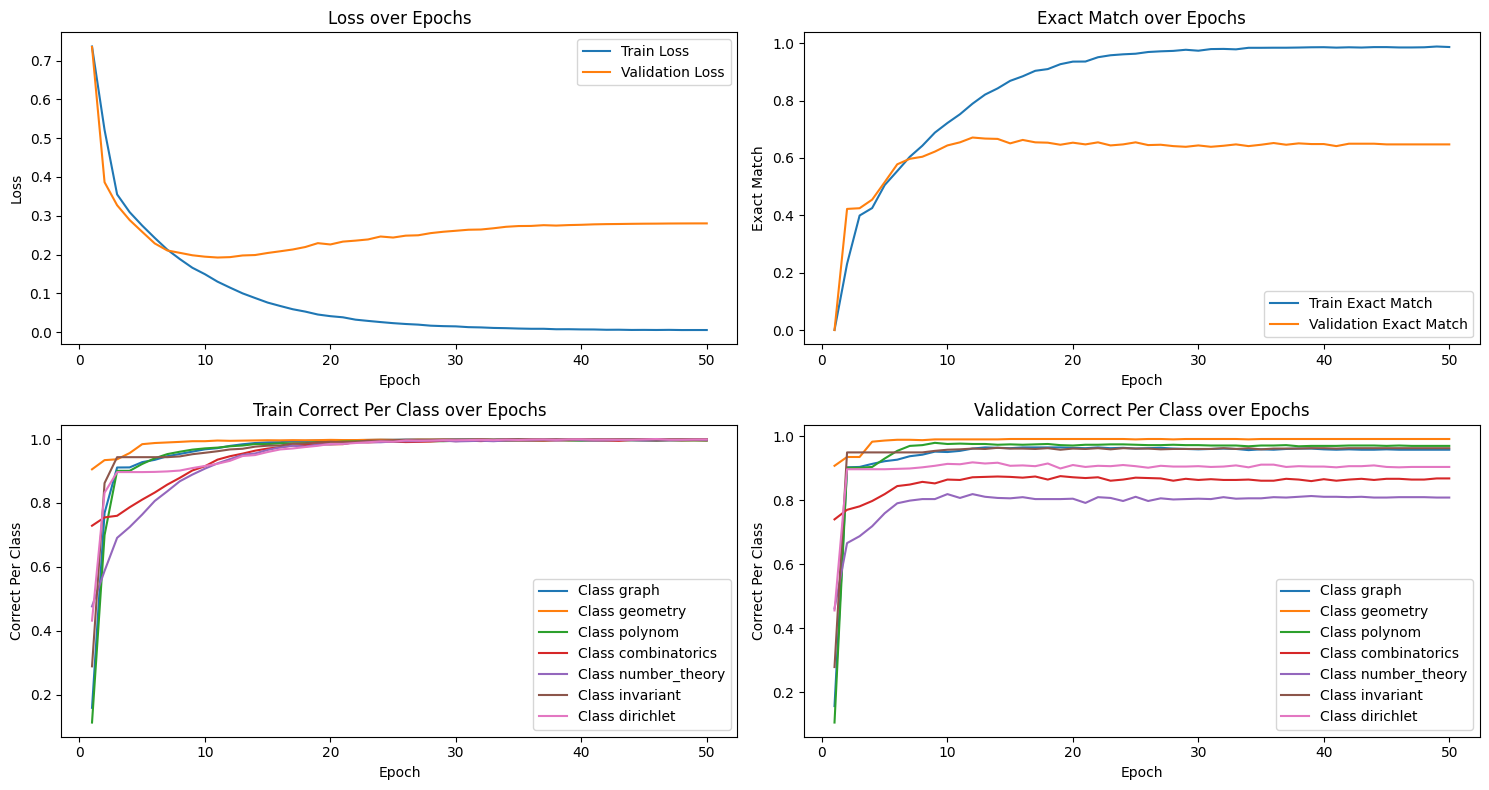

In [ ]:
rubert_tiny_full_tuned = train_transformer(transformer_model=rubert_tiny_transformer_model,
                      epochs=50,
                      train_data_loader=train_dataloader,
                      val_data_loader=test_dataloader,
                      experiment_name= 'rubert_tiny_full_tuned',
                      device=device,
                      freeze_backbone=False,
                      start_from_chp=False,
                      lr=2e-5,
                      scheduler='get_cosine_schedule_with_warmup')

**минивывод** с заморозкой backbone учится достаточно быстро, после 10 эпох метрика не растет, несмотря на то, что по loss'у переобучения нет, а обучение есть. Если bacbone разморозить - метрики заметно выше, но уже после 10й эпохи заметно переобучение.

### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [ ]:
ds = make_ds(df, model_name='tbs17/MathBert', label_columns = LABEL_COLUMNS )
ds_s=ds.train_test_split(test_size=0.2)
train_dataloader = DataLoader(ds_s['train'], batch_size=16, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(ds_s['test'], batch_size=16, shuffle=False, collate_fn=collate_fn)

Map:   0%|          | 0/4178 [00:00<?, ? examples/s]

#### Сначала запускаем на русском датасете

In [ ]:
mathbert_transformer_model = TransformerClassificationModel('tbs17/MathBert', num_labels=7 )

19


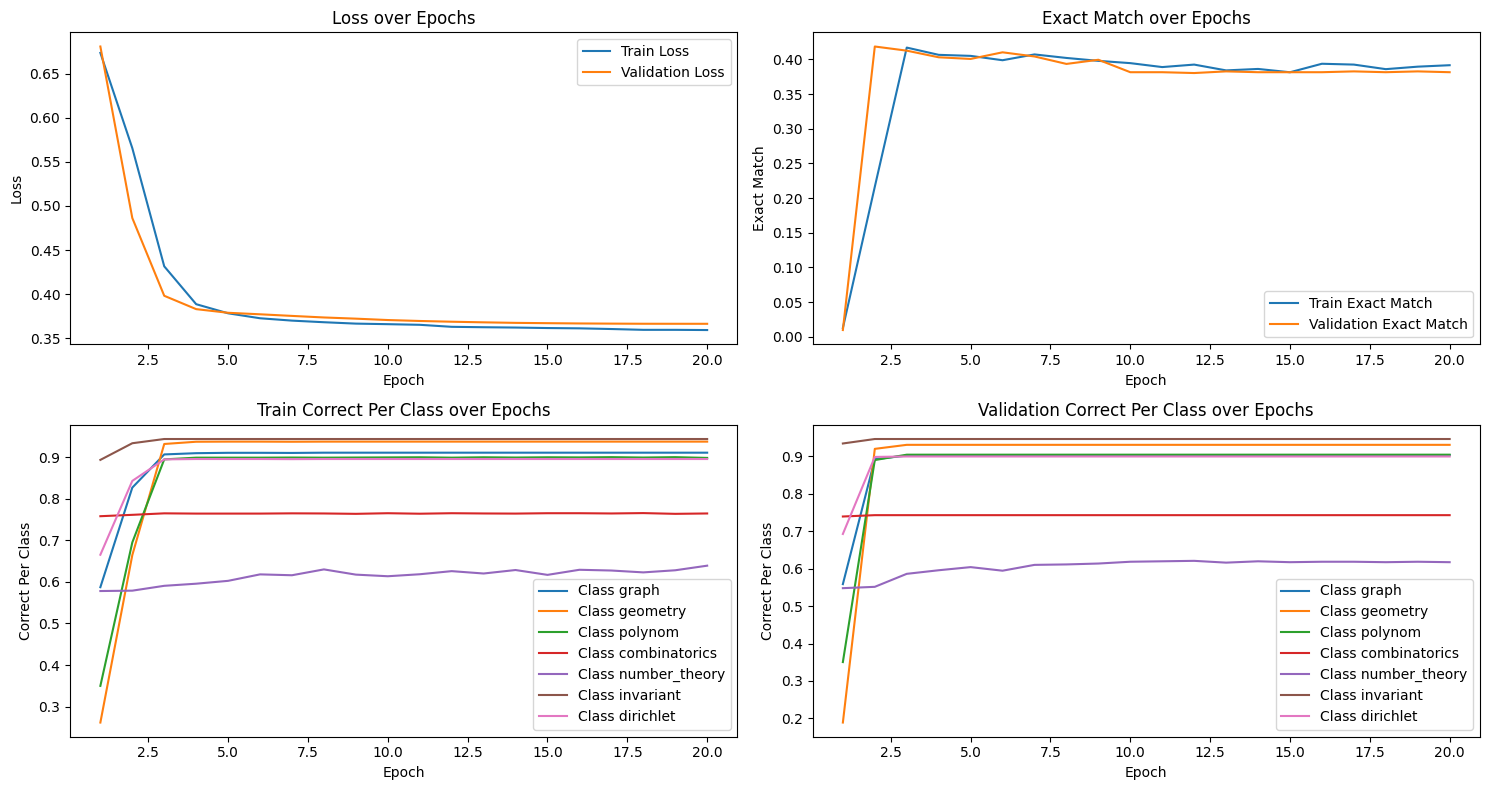

In [ ]:
mathbert_freezed = train_transformer(transformer_model=mathbert_transformer_model,
                      epochs=20,
                      train_data_loader=train_dataloader,
                      val_data_loader=test_dataloader,
                      experiment_name= 'mathbert_freezed',
                      device=device,
                      freeze_backbone=True,
                      start_from_chp=False,
                      lr=2e-5,
                      scheduler='get_cosine_schedule_with_warmup')

19


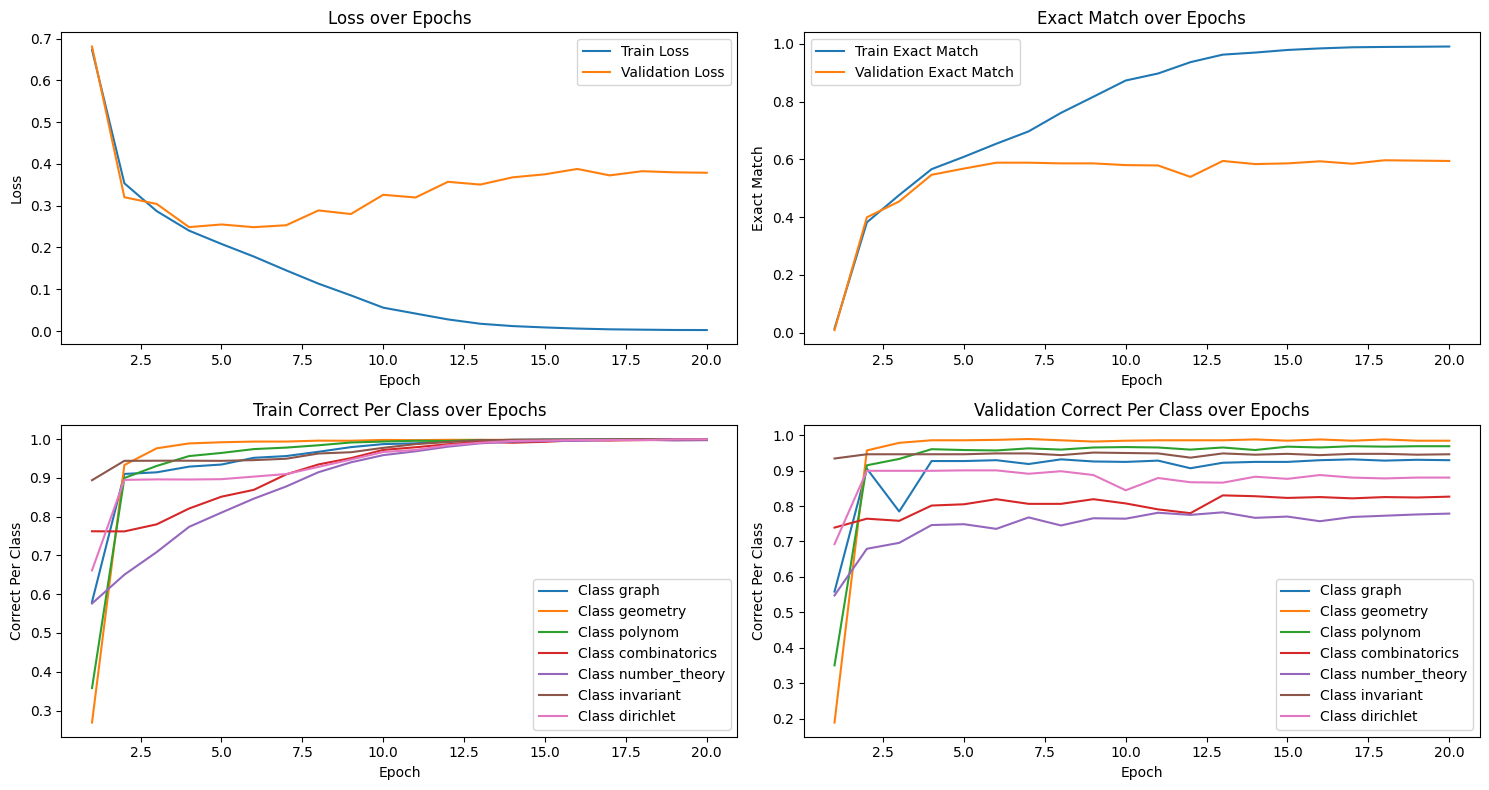

In [ ]:
mathbert_full_tuned = train_transformer(transformer_model=mathbert_transformer_model,
                      epochs=20,
                      train_data_loader=train_dataloader,
                      val_data_loader=test_dataloader,
                      experiment_name= 'mathbert_full_tuned',
                      device=device,
                      freeze_backbone=False,
                      start_from_chp=False,
                      lr=2e-5,
                      scheduler='get_cosine_schedule_with_warmup')


**минивывод** mathBert знает только англйский. Русский текст он токенизирует по буквам. Несмотря на это после разморозки backbone он умудрился почти дотянуться по метрикам до rubert-tiny. Переобучение начинается очень быстро.

#### Пробуем на переведенном датасете
Но вообще-то mathbert обучался на английский текстах, поэтому попробуем запустить обучение на английском датасете (просто переведенный гуглом изначальный русский эксель-файл)

In [ ]:
ds_en = make_ds(df_en, model_name='tbs17/MathBert', label_columns = LABEL_COLUMNS )
ds_en_s=ds_en.train_test_split(test_size=0.2)
train_dataloader_en = DataLoader(ds_en_s['train'], batch_size=16, shuffle=True, collate_fn=collate_fn)
test_dataloader_en = DataLoader(ds_en_s['test'], batch_size=16, shuffle=False, collate_fn=collate_fn)

Map:   0%|          | 0/4178 [00:00<?, ? examples/s]

mathBert freezed

29


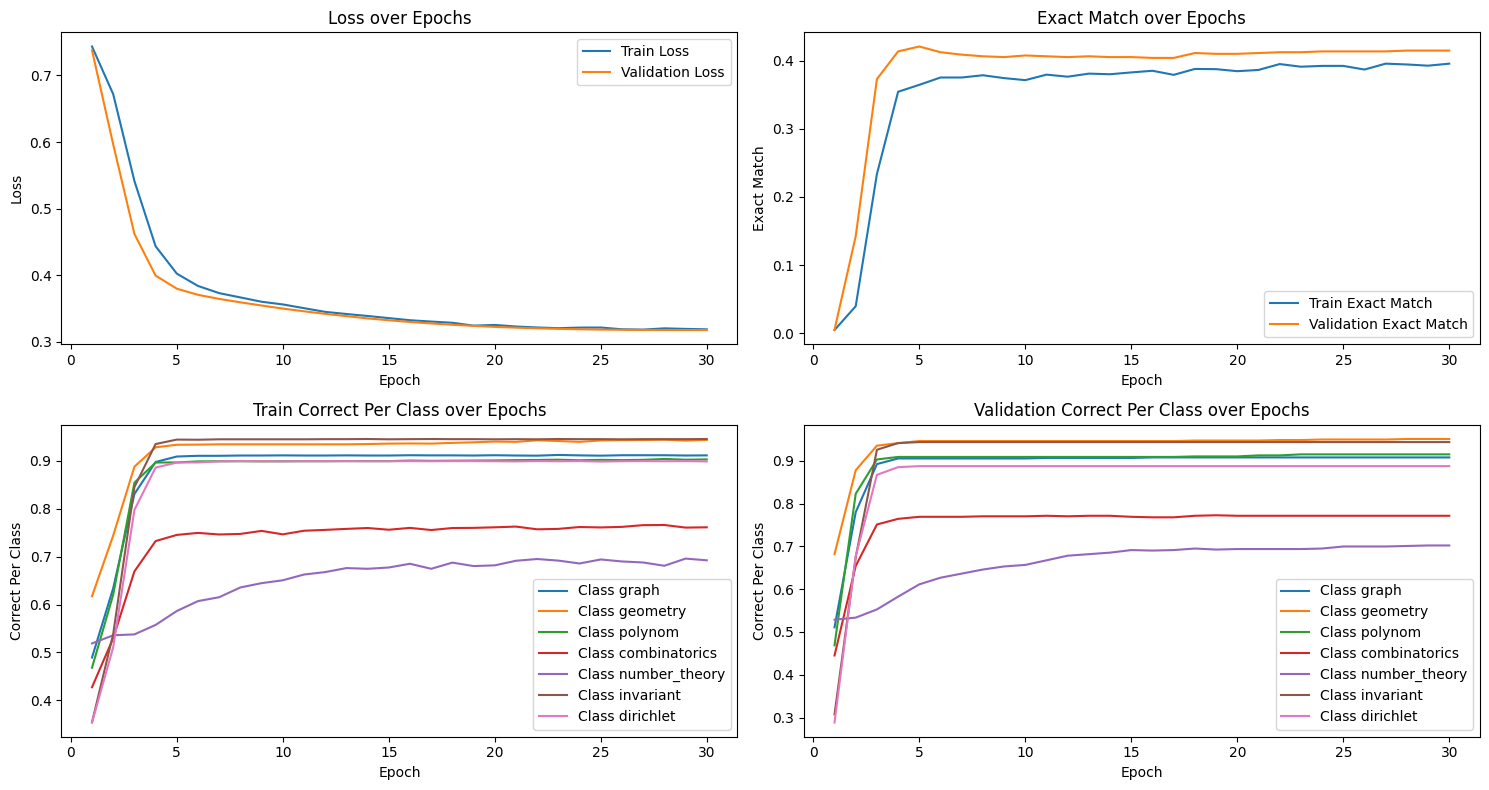

In [ ]:
mathbert_en_freezed = train_transformer(transformer_model=mathbert_transformer_model,
                      epochs=30,
                      train_data_loader=train_dataloader_en,
                      val_data_loader=test_dataloader_en,
                      experiment_name= 'mathbert_freezed',
                      device=device,
                      freeze_backbone=True,
                      start_from_chp=False,
                      lr=2e-5,
                      scheduler='get_cosine_schedule_with_warmup')

mathBert full tuned

29


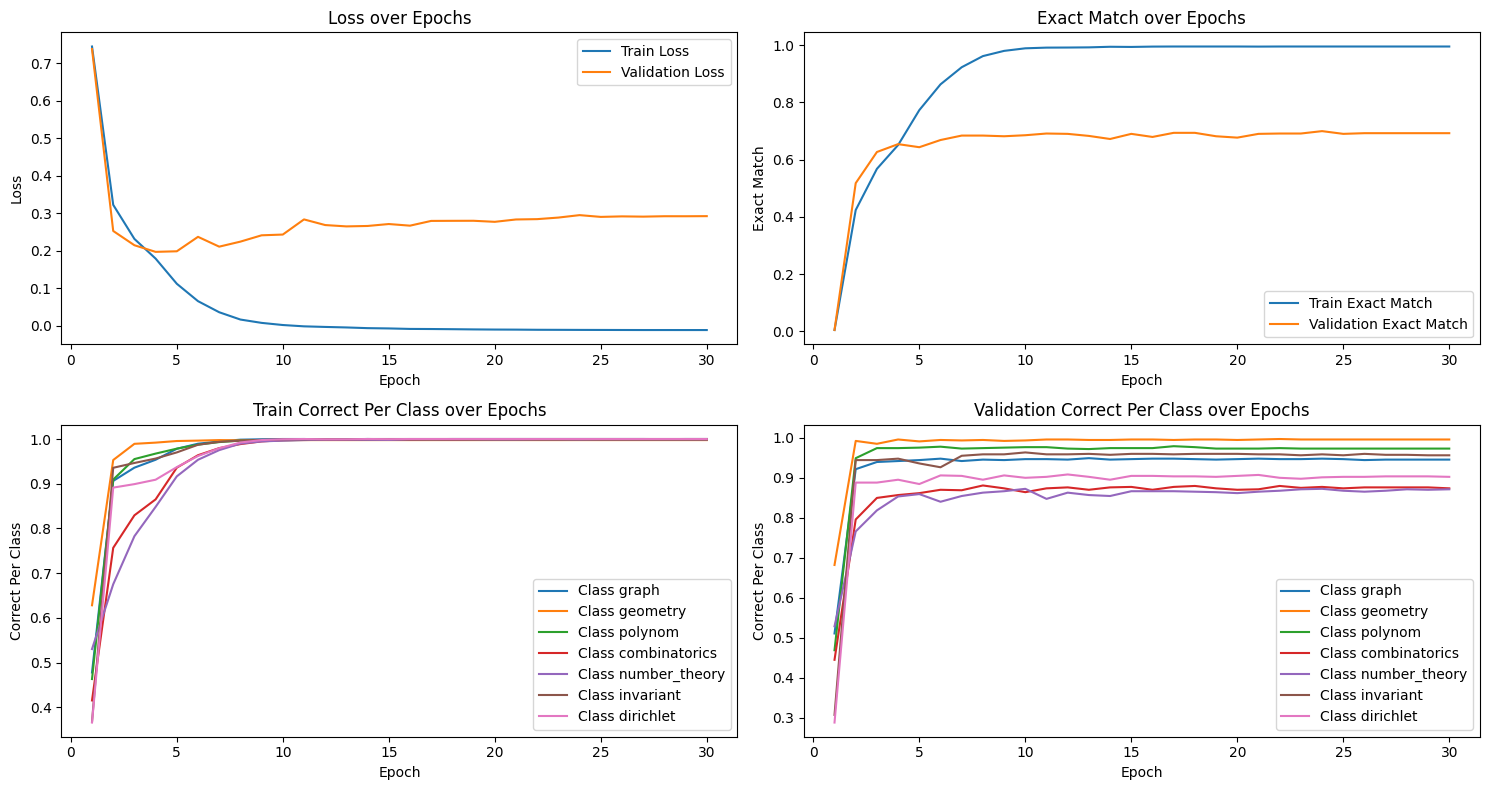

In [ ]:
mathbert_en_full_tuned = train_transformer(transformer_model=mathbert_transformer_model,
                      epochs=30,
                      train_data_loader=train_dataloader_en,
                      val_data_loader=test_dataloader_en,
                      experiment_name= 'mathbert_en_full_train',
                      device=device,
                      freeze_backbone=False,
                      start_from_chp=False,
                      lr=2e-5,
                      scheduler='get_cosine_schedule_with_warmup')

**минивывод** mathBert показал качество, сравнимое с rubert-tiny2 при всех размороженных весах (при подаче переведенного датасета). Вот только у него 12 слоев внимания, вместо 3х, что очень заметно на производительности.

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [ ]:
def visualize_attention_map(text, model, tokenizer, att_head_number=0, att_slice_from= None, att_slice_to=None, ax=None):
    model.full_output=True
    model.to('cpu')
    attention_from_layer=0
    sample_idx = 0
    # Переводим модель в режим оценки
    model.eval()
    # токенизируем текст
    text_tokenized = tokenizer(text, return_tensors='pt' )
    token_list = tokenizer.convert_ids_to_tokens(text_tokenized['input_ids'].squeeze(0))[att_slice_from:att_slice_to]
    # Получаем выходные данные и веса внимания
    with torch.no_grad():
        outputs = model(input_ids=text_tokenized['input_ids'],
                        attention_mask = text_tokenized['attention_mask'])
    attn_weights = outputs['full_output']['attentions'][attention_from_layer][sample_idx]
    # Выбираем голову внимания для визуализации
    attn_weights = attn_weights[att_head_number]

    # Нормализуем веса внимания
    att_map = attn_weights.cpu().numpy()
    # вырезаем кусочек для визуализации
    # if att_slice is not None:
    att_map = att_map[att_slice_from:att_slice_to, att_slice_from:att_slice_to]
    # Нормализуем веса внимания
    att_map = att_map / np.max(att_map)

    if ax is None:
        plt.show()
    else:
        ax.imshow(att_map, cmap='viridis')
#         ax.colorbar()
        ax.set_title(f'Attention Map of the First Layer head number {att_head_number}')
        ax.set_xticks(np.arange(len(token_list)))
        ax.set_xticklabels(token_list, rotation=90)
        ax.set_yticks(np.arange(len(token_list)))
        ax.set_yticklabels(token_list)

In [ ]:
def visualize_attention_map_2(texts, model, tokenizer, att_head_number=0, att_slice_from=None, att_slice_to=None):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, text in enumerate(texts):
        # Очищаем текущую ось перед визуализацией
        axes[i].clear()
        # Вызываем функцию для текущего текста
        visualize_attention_map(text, model, tokenizer, att_head_number=att_head_number, att_slice_from=att_slice_from, att_slice_to=att_slice_to, ax=axes[i])

    for i in range(len(texts), 3):
        axes[i].remove()

    plt.show()

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

**ВНИМАНИЕ** тут я привожу карты в том порядке, в каком просят составители дз. Ниже - скомпоновал удобным для себя способом.

In [ ]:
model_name1='cointegrated/rubert-tiny2'
ds1 = make_ds(df, model_name=model_name1, label_columns = LABEL_COLUMNS )
tokenizer1 = AutoTokenizer.from_pretrained(model_name1)

model_name2='tbs17/MathBert'
ds2 = make_ds(df, model_name=model_name2, label_columns = LABEL_COLUMNS )
tokenizer2 = AutoTokenizer.from_pretrained(model_name2)

Map:   0%|          | 0/4178 [00:00<?, ? examples/s]

Map:   0%|          | 0/4178 [00:00<?, ? examples/s]

In [ ]:
# токенизированные фразы
test_phrase11 = tokenizer1.decode(ds1[0]['input_ids'][1:-1])
test_phrase12 = tokenizer1.decode(ds1[100]['input_ids'][1:-1])
test_phrase13 = tokenizer1.decode(ds1[2000]['input_ids'][1:-1])
texts1 = [test_phrase11, test_phrase12, test_phrase13]

test_phrase21 = tokenizer2.decode(ds2[0]['input_ids'][1:-1])
test_phrase22 = tokenizer2.decode(ds2[100]['input_ids'][1:-1])
test_phrase23 = tokenizer2.decode(ds2[2000]['input_ids'][1:-1])
texts2 = [test_phrase21, test_phrase22, test_phrase23]

In [ ]:
model_name2='tbs17/MathBert'
ds3 = make_ds(df_en, model_name=model_name2, label_columns = LABEL_COLUMNS )
tokenizer3 = AutoTokenizer.from_pretrained(model_name2)

test_phrase31 = tokenizer3.decode(ds3[0]['input_ids'][1:-1])
test_phrase32 = tokenizer3.decode(ds3[100]['input_ids'][1:-1])
test_phrase33 = tokenizer3.decode(ds3[2000]['input_ids'][1:-1])
texts3 = [test_phrase31, test_phrase32, test_phrase33]

Map:   0%|          | 0/4178 [00:00<?, ? examples/s]

#### До обучения rubert-tiny2

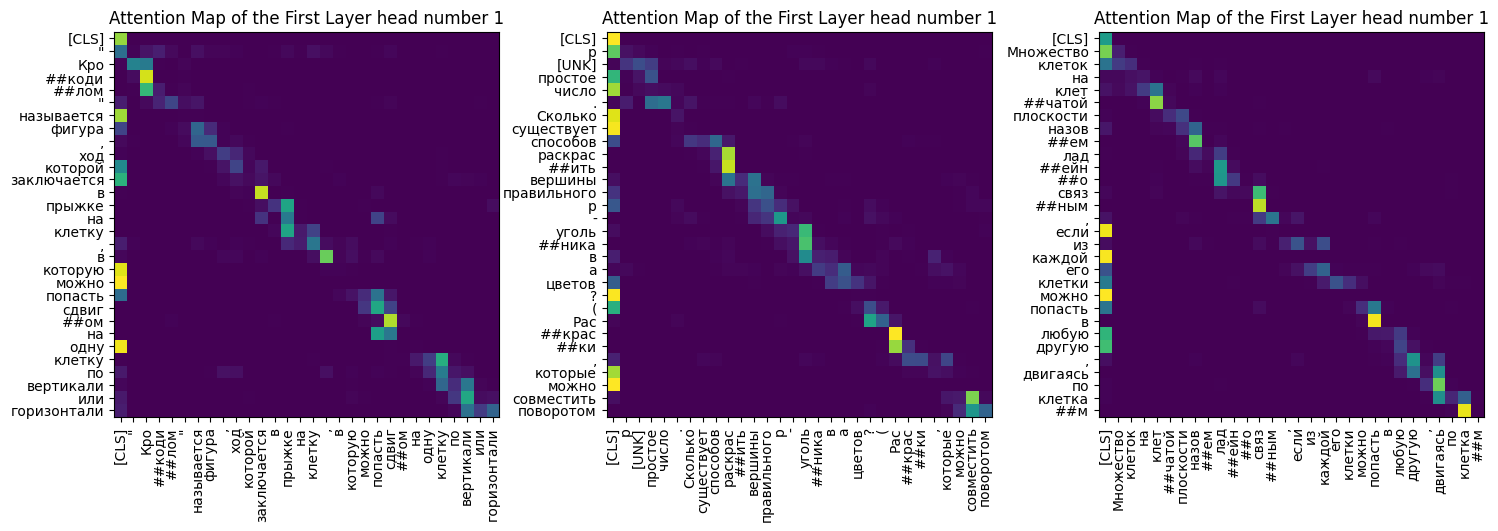

In [ ]:
visualize_attention_map_2(texts=texts1,
                          model=rubert_tiny_transformer_model,
                          tokenizer=tokenizer1,
                          att_head_number=1,
                          att_slice_from=None,
                          att_slice_to=30)

в основномобращает внимание на сам токен

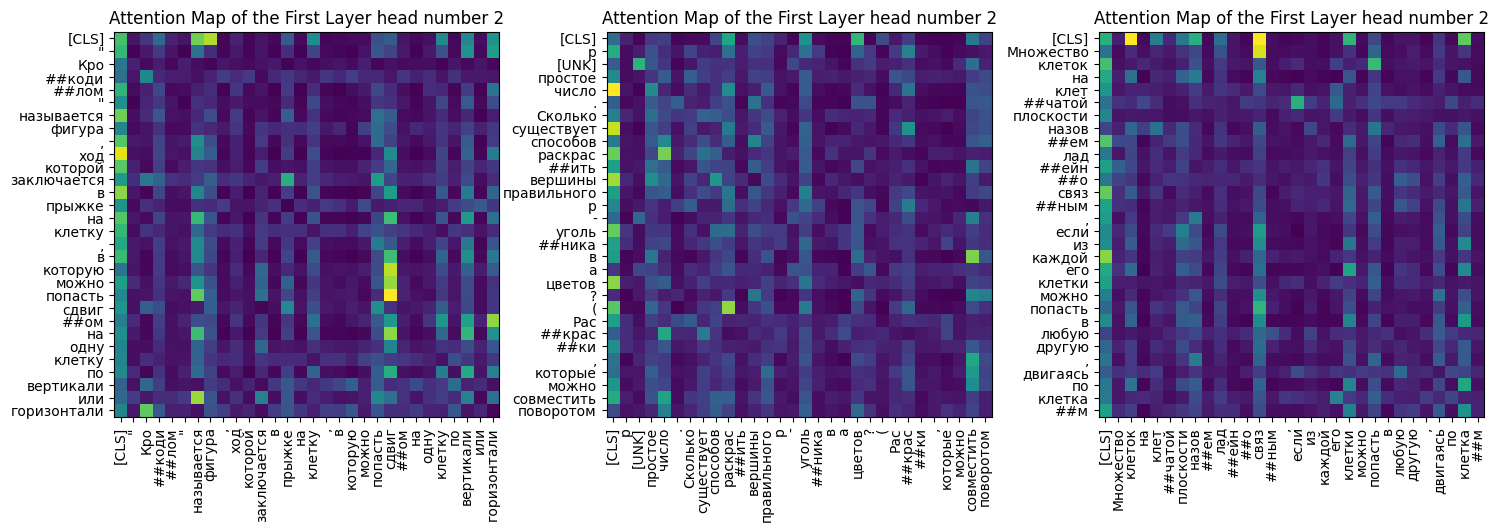

In [ ]:
visualize_attention_map_2(texts=texts1,
                          model=rubert_tiny_transformer_model,
                          tokenizer=tokenizer1,
                          att_head_number=2,
                          att_slice_from=None,
                          att_slice_to=30)

смысл разман на большом количестве токенов в предложении, достаточно понятно связанных по смыслу:
- "сдвиг" <-> "в которую можно попасть"
- "число" <-> "способов раскрасить вершины"
- "связь" <-> "множество клеток ... попасть"

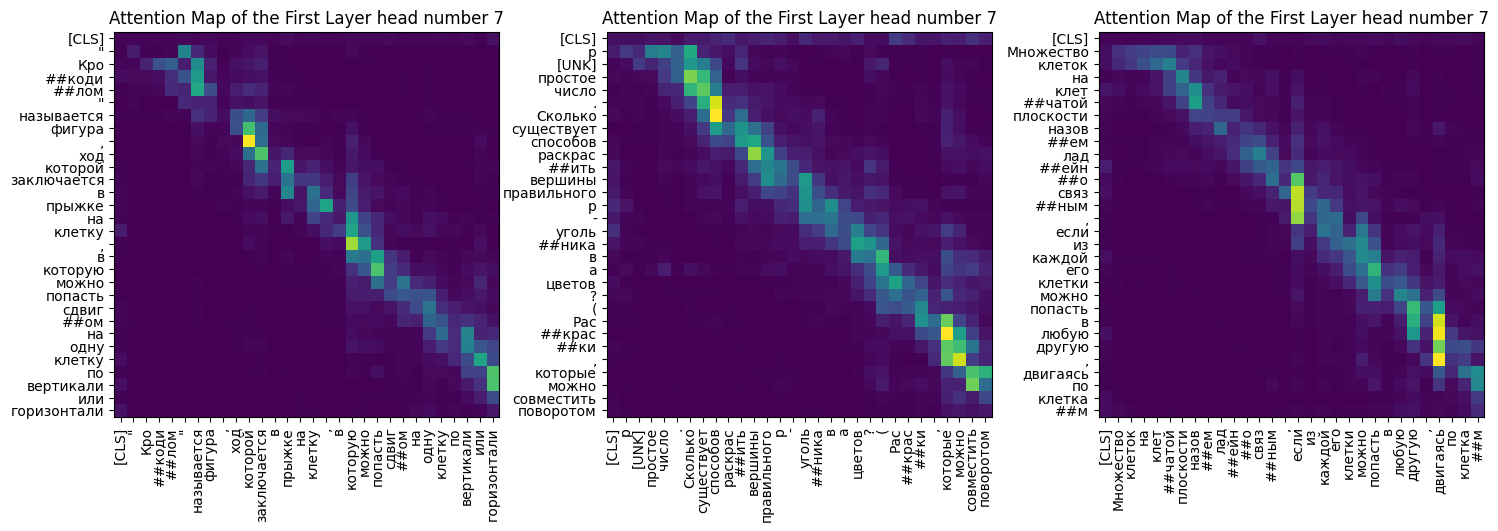

In [ ]:
visualize_attention_map_2(texts=texts1,
                          model=rubert_tiny_transformer_model,
                          tokenizer=tokenizer1,
                          att_head_number=7,
                          att_slice_from=None,
                          att_slice_to=30)

обращает внимание на соседние слова

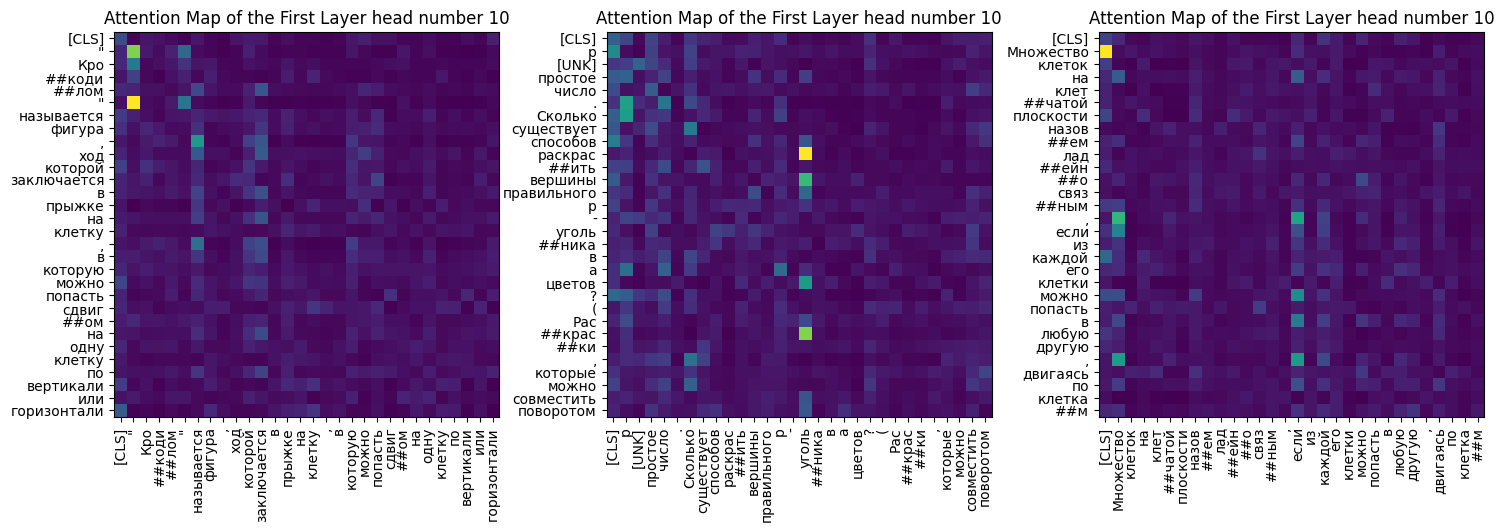

In [ ]:
visualize_attention_map_2(texts=texts1,
                          model=rubert_tiny_full_tuned,
                          tokenizer=tokenizer1,
                          att_head_number=10,
                          att_slice_from=None,
                          att_slice_to=30)

как вторая карта внимания, но менее ярко

#### До обучения mathbert

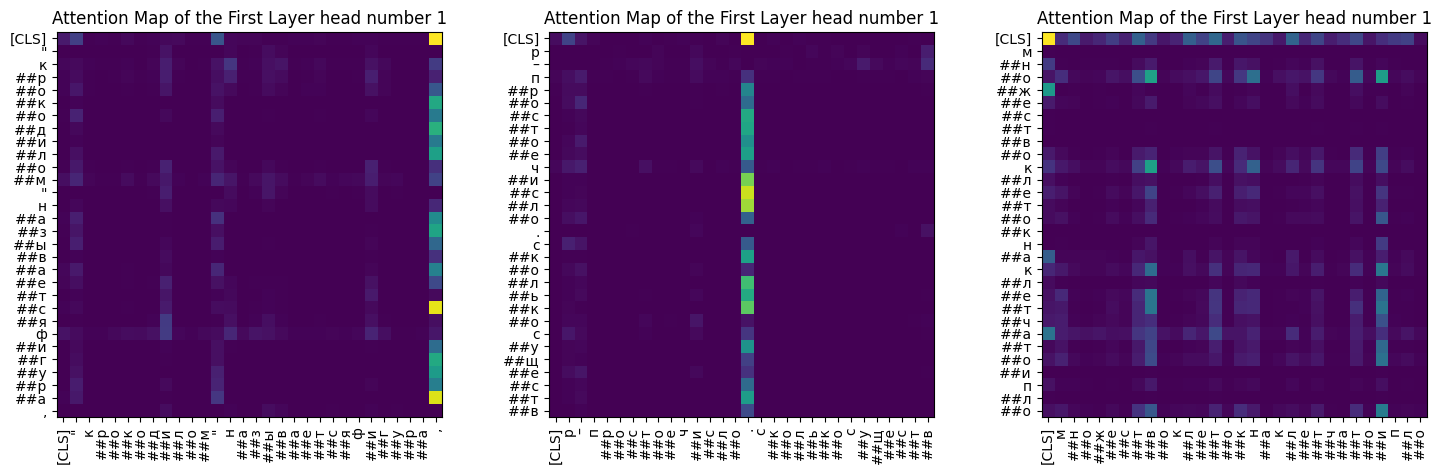

In [ ]:
visualize_attention_map_2(texts=texts2,
                          model=mathbert_transformer_model,
                          tokenizer=tokenizer2,
                          att_head_number=1,
                          att_slice_from=None,
                          att_slice_to=30)

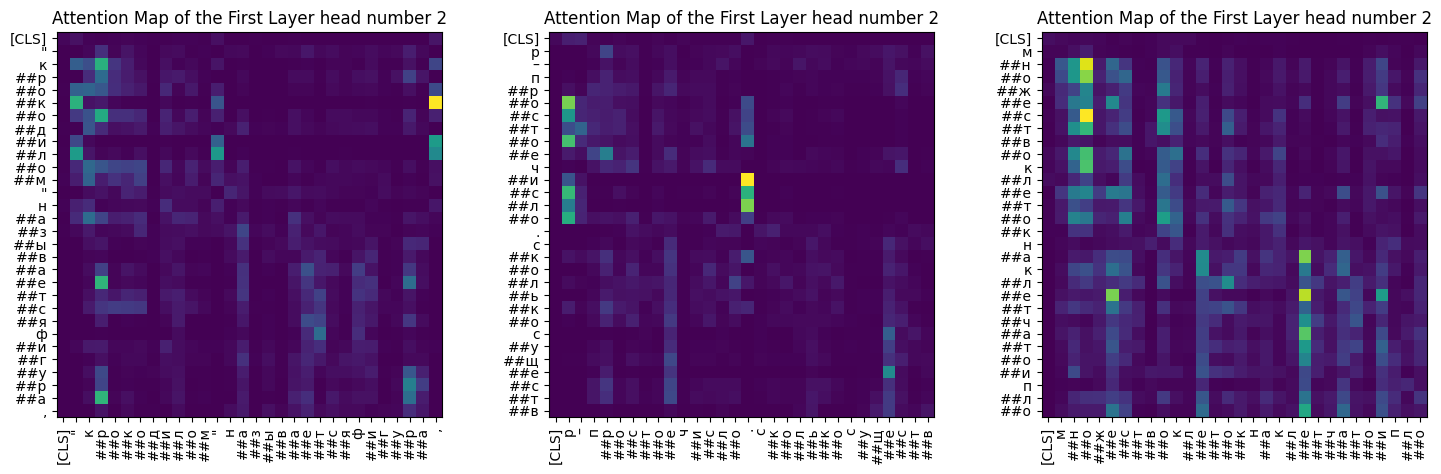

In [ ]:
visualize_attention_map_2(texts=texts2,
                          model=mathbert_transformer_model,
                          tokenizer=tokenizer2,
                          att_head_number=2,
                          att_slice_from=None,
                          att_slice_to=30)

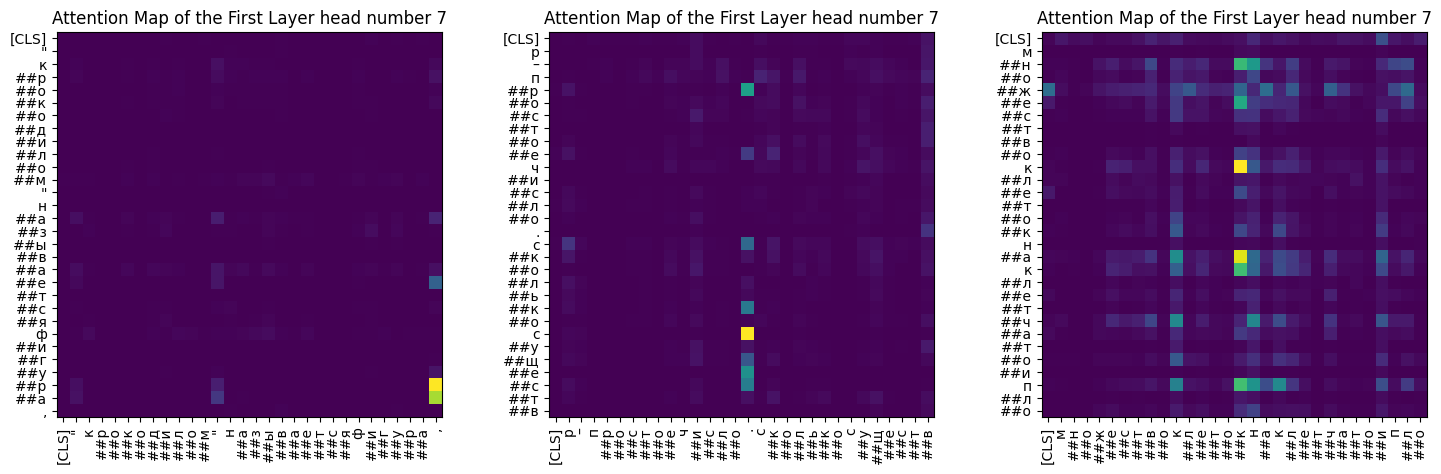

In [ ]:
visualize_attention_map_2(texts=texts2,
                          model=mathbert_transformer_model,
                          tokenizer=tokenizer2,
                          att_head_number=7,
                          att_slice_from=None,
                          att_slice_to=30)

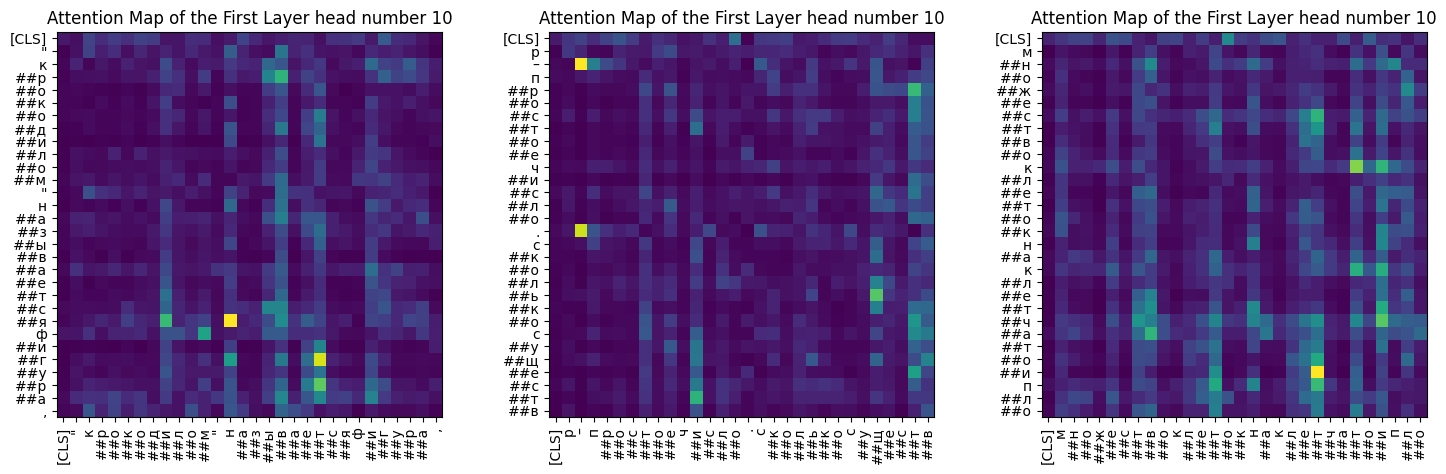

In [ ]:
visualize_attention_map_2(texts=texts2,
                          model=mathbert_transformer_model,
                          tokenizer=tokenizer2,
                          att_head_number=10,
                          att_slice_from=None,
                          att_slice_to=30)

на русских текстах не интерпретируемо. Наверное, если бы текстов было много, обучение долгое, то он бы смог сложить из букв слова (и тогда обращал бы внимание на соседние токены). Но так модель выявляет что-то невразумительное.

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

#### rubert-tiny2 обученный, backbone замороженный
а вто тут как раз неудобно смотреть: приходится мотать вверх-вниз. Поэтому, чтобы видеть что изменилось в моделе при обучении перегруппировал граффики снизу. там же и выводы

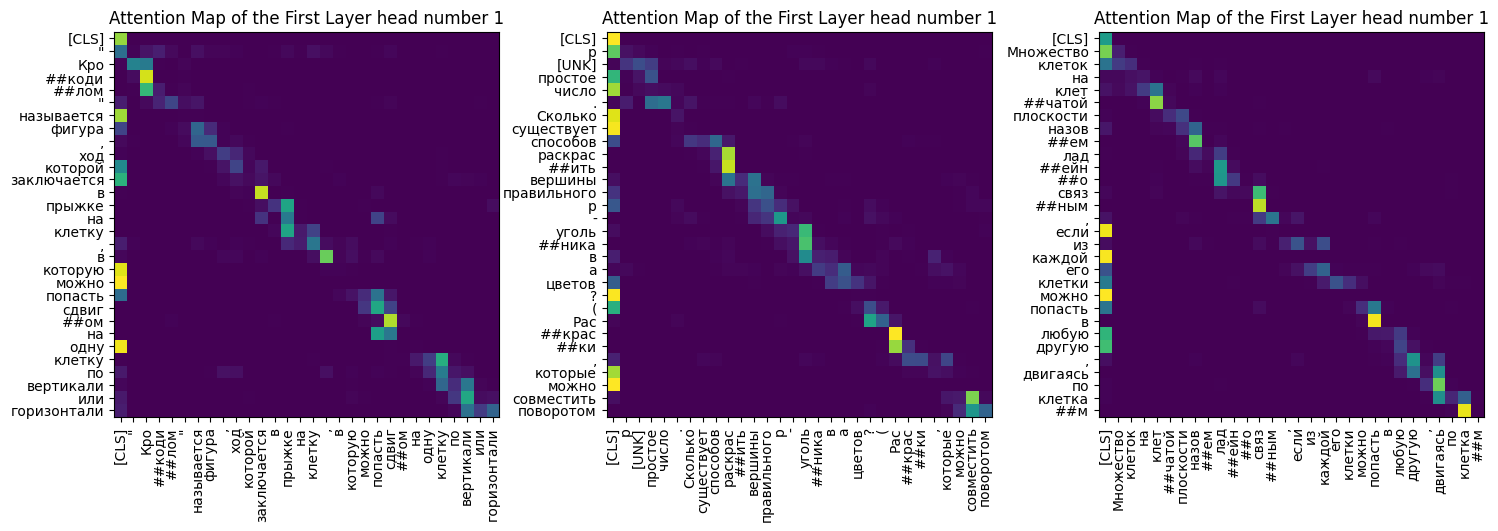

In [ ]:
visualize_attention_map_2(texts=texts1,
                          model=rubert_tiny_freezed,
                          tokenizer=tokenizer1,
                          att_head_number=1,
                          att_slice_from=None,
                          att_slice_to=30)

#### mathbert обученный, backbone замороженный

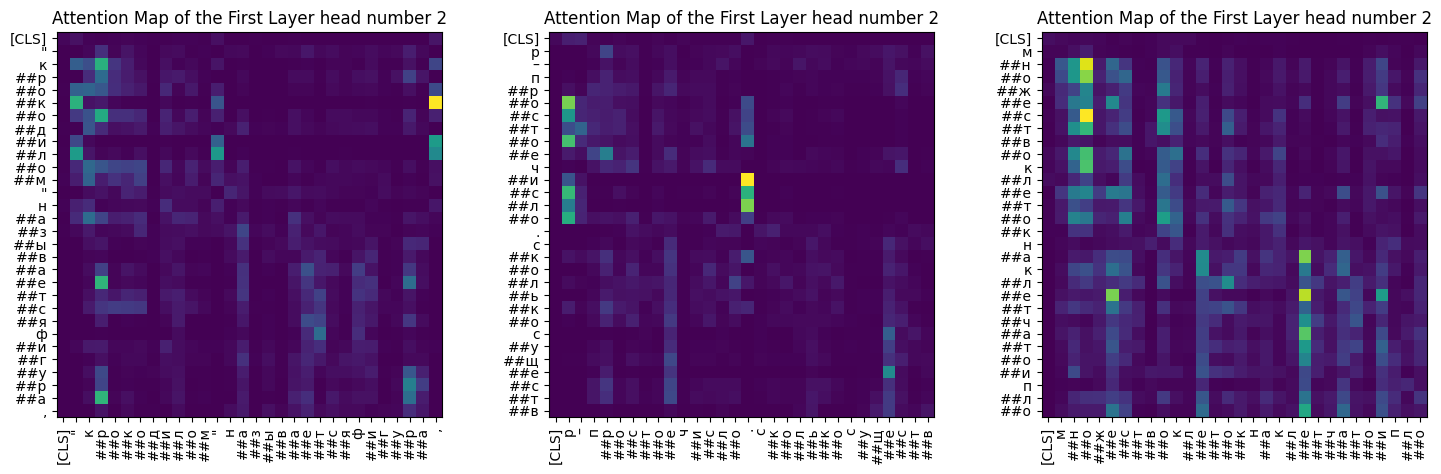

In [ ]:
visualize_attention_map_2(texts=texts2,
                          model=mathbert_freezed,
                          tokenizer=tokenizer2,
                          att_head_number=2,
                          att_slice_from=None,
                          att_slice_to=30)

#### Mathbert обученный на EN, backbone заморожен

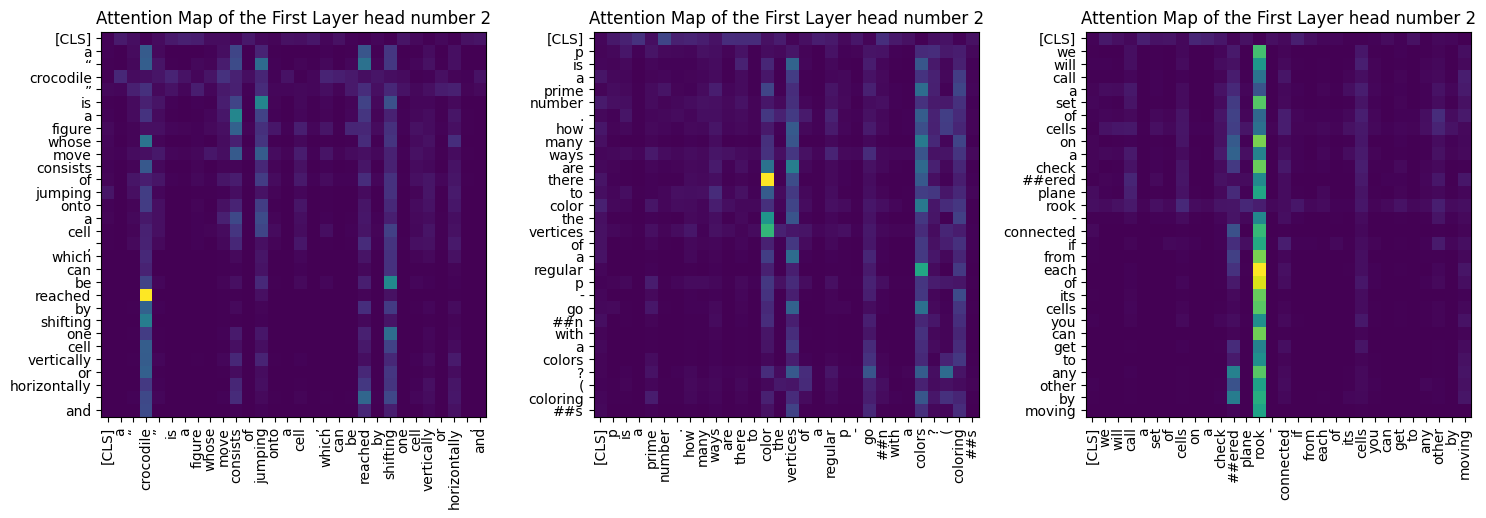

In [ ]:
visualize_attention_map_2(texts=texts3,
                          model=mathbert_en_freezed,
                          tokenizer=tokenizer2,
                          att_head_number=2,
                          att_slice_from=None,
                          att_slice_to=30)

#### rubert-tiny2 обученный полностью

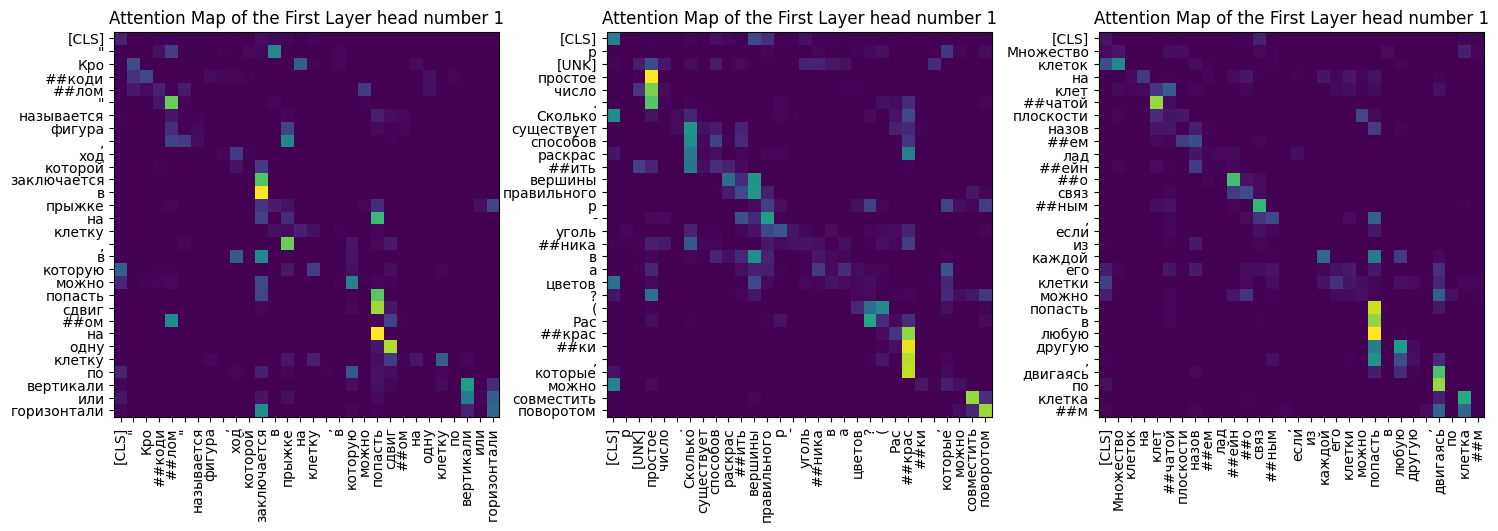

In [ ]:
visualize_attention_map_2(texts=texts1,
                          model=rubert_tiny_full_tuned,
                          tokenizer=tokenizer1,
                          att_head_number=1,
                          att_slice_from=None,
                          att_slice_to=30)

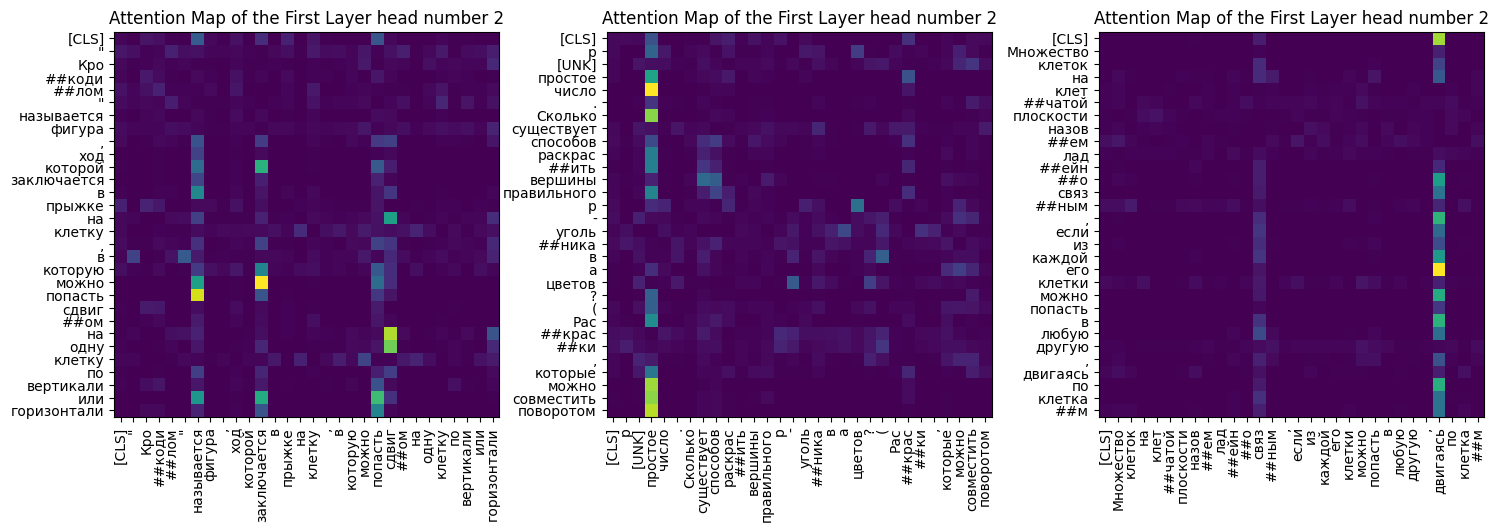

In [ ]:
visualize_attention_map_2(texts=texts1,
                          model=rubert_tiny_full_tuned,
                          tokenizer=tokenizer1,
                          att_head_number=2,
                          att_slice_from=None,
                          att_slice_to=30)

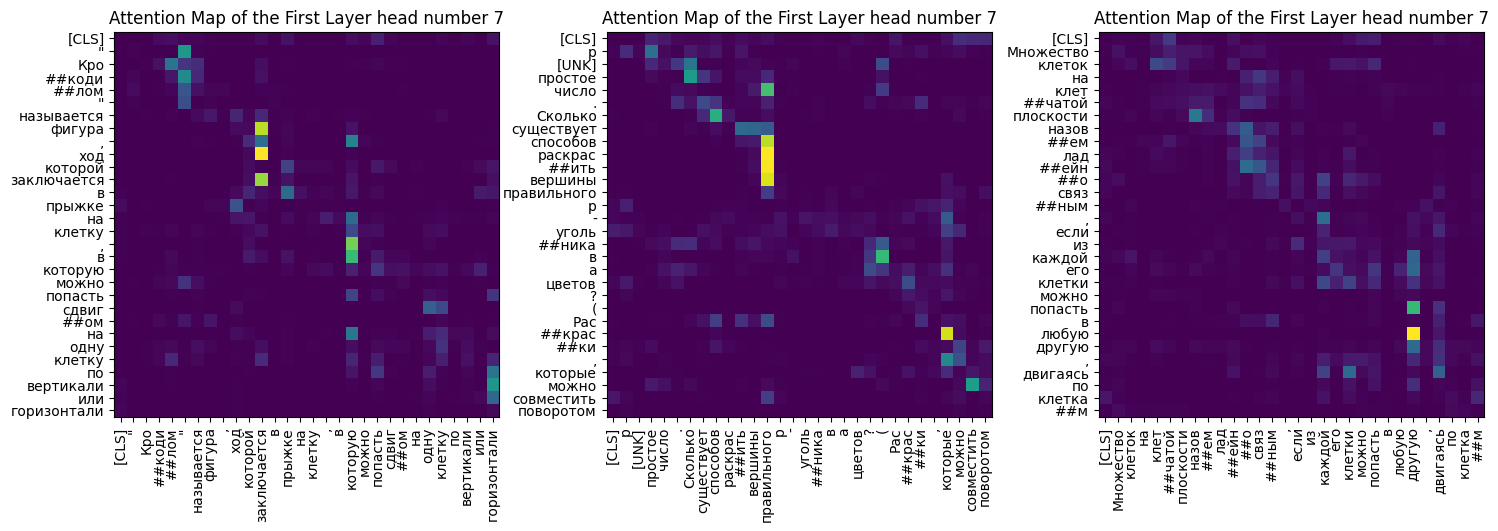

In [ ]:
visualize_attention_map_2(texts=texts1,
                          model=rubert_tiny_full_tuned,
                          tokenizer=tokenizer1,
                          att_head_number=7,
                          att_slice_from=None,
                          att_slice_to=30)

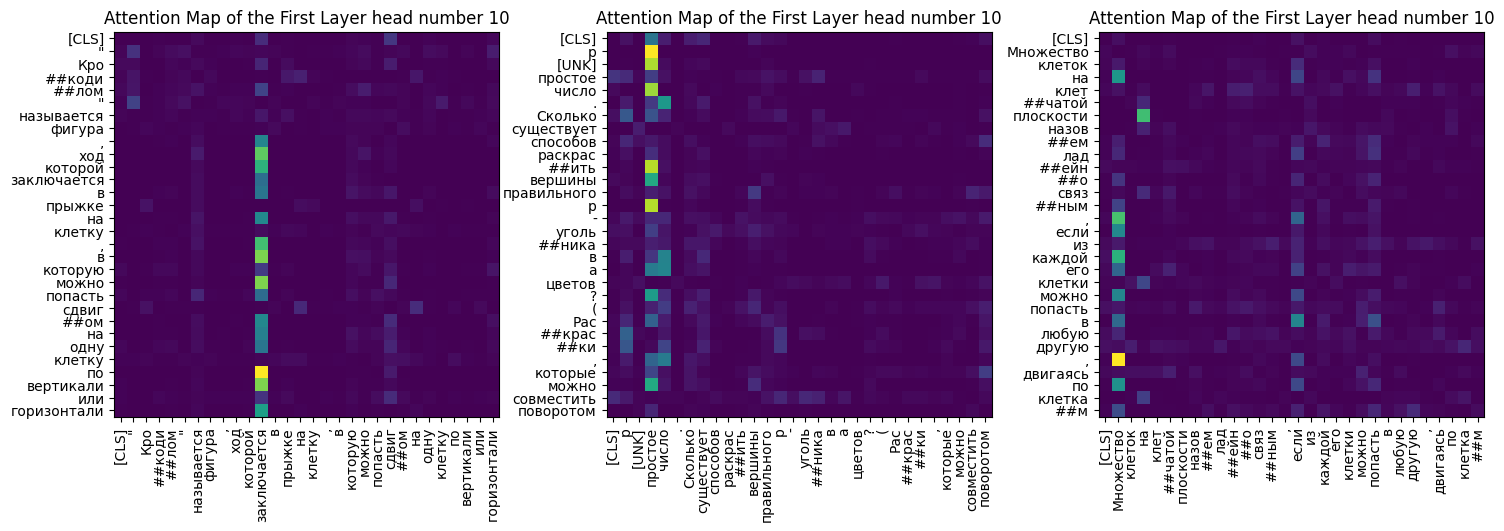

In [ ]:
visualize_attention_map_2(texts=texts1,
                          model=rubert_tiny_full_tuned,
                          tokenizer=tokenizer1,
                          att_head_number=10,
                          att_slice_from=None,
                          att_slice_to=30)

#### mathbert обученный полностью

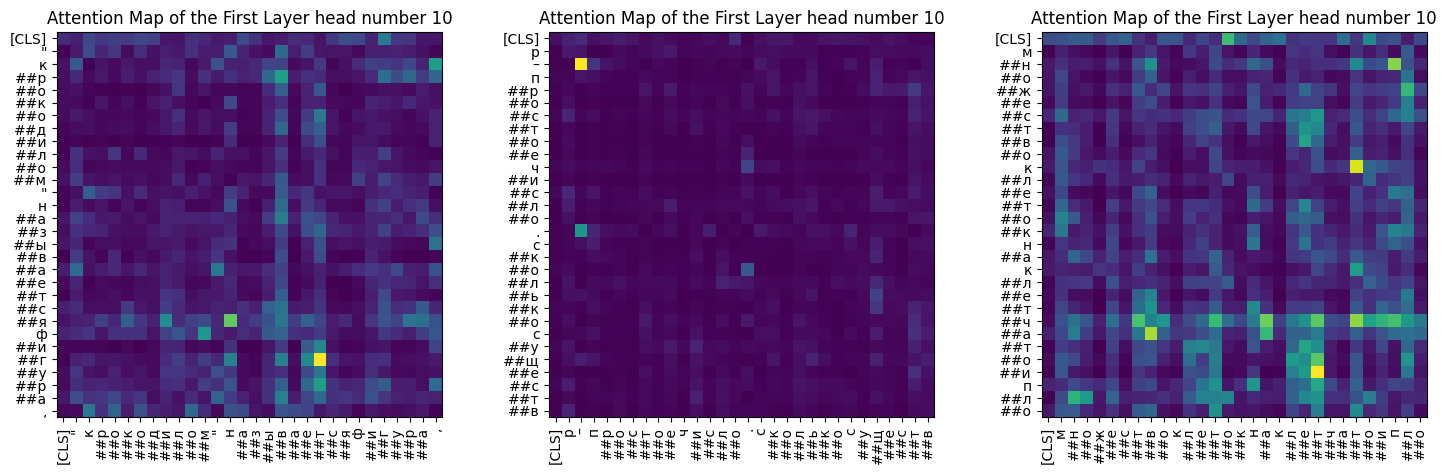

In [ ]:
visualize_attention_map_2(texts=texts2,
                          model=mathbert_full_tuned,
                          tokenizer=tokenizer2,
                          att_head_number=10,
                          att_slice_from=None,
                          att_slice_to=30)

#### Mathbert обученный полностью, на EN текстах

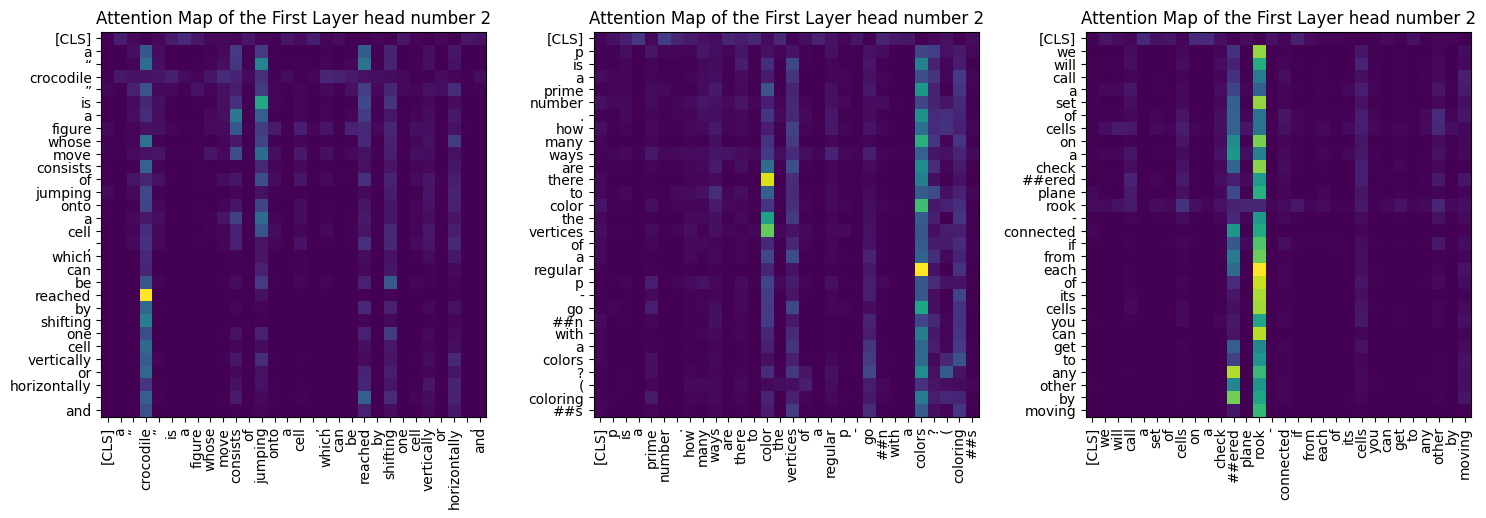

In [ ]:
visualize_attention_map_2(texts=texts3,
                          model=mathbert_en_full_tuned,
                          tokenizer=tokenizer2,
                          att_head_number=2,
                          att_slice_from=None,
                          att_slice_to=30)

# Чуть в более удобной компановке краты внимания

## rubert-tiny до обучения (и с замороженным backbone)

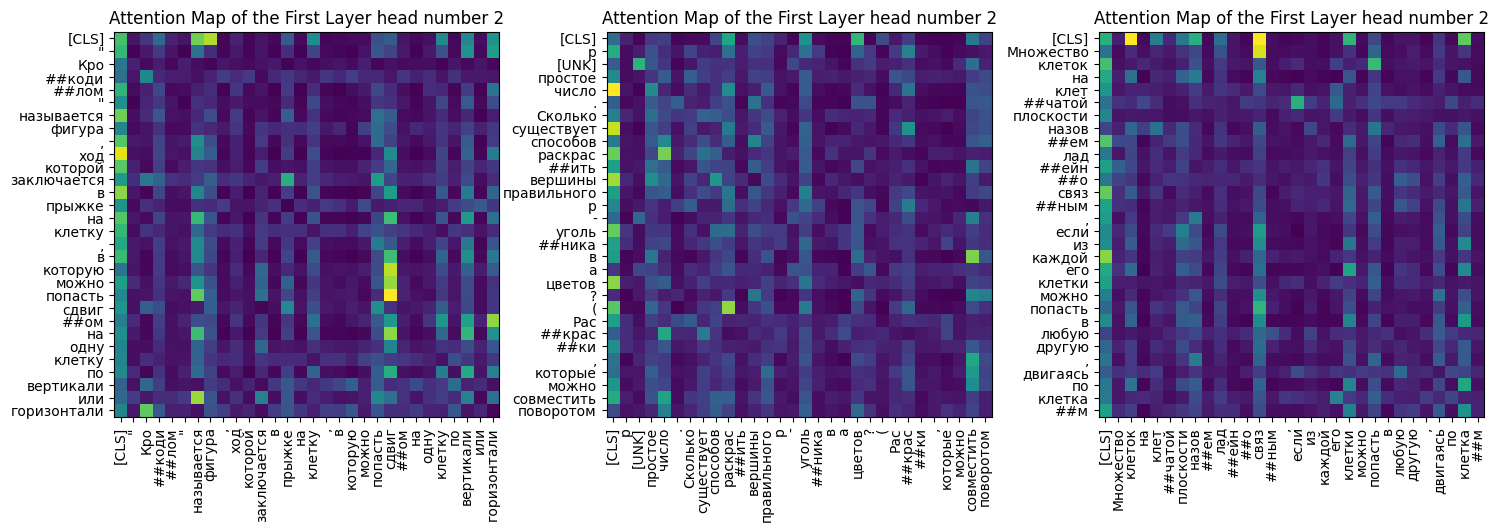

In [ ]:
visualize_attention_map_2(texts=texts1,
                          model=rubert_tiny_transformer_model,
                          tokenizer=tokenizer1,
                          att_head_number=2,
                          att_slice_from=None,
                          att_slice_to=30)

## rubert-tiny полностью обученный

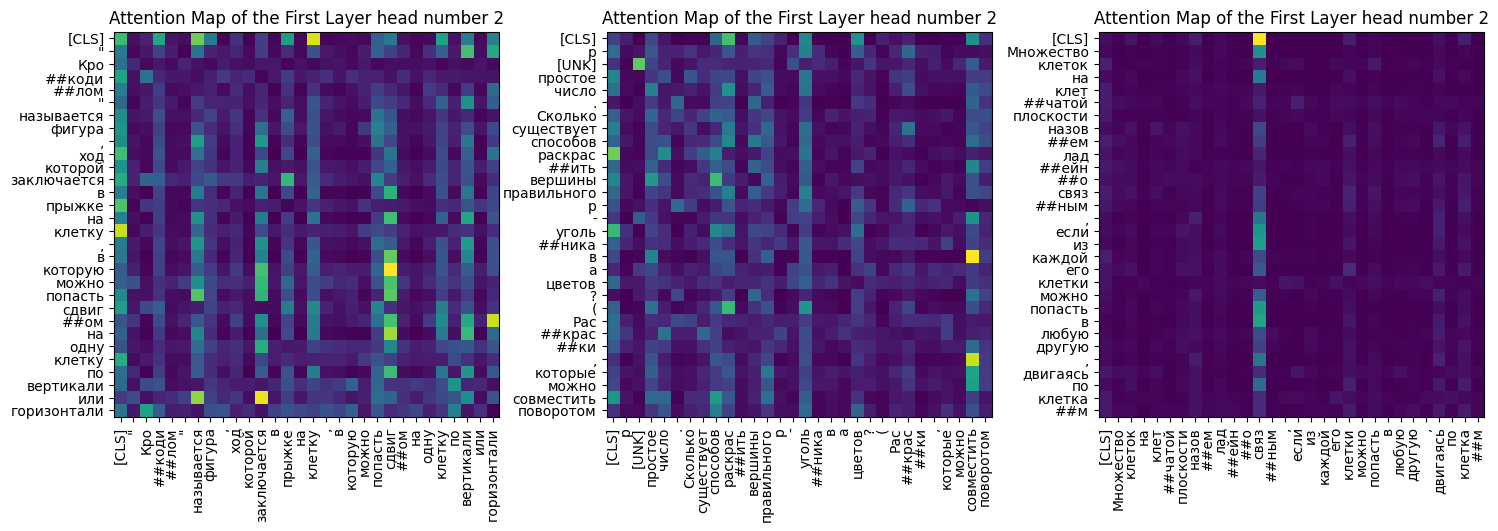

In [ ]:
visualize_attention_map_2(texts=texts1,
                          model=rubert_tiny_full_tuned,
                          tokenizer=tokenizer1,
                          att_head_number=2,
                          att_slice_from=None,
                          att_slice_to=30)

внимание стало более сконцентрированным на ключевых словах и междуними:
1. сдвиг
2. способов раскрасить
3. связ (из "ладейносвязным")

## mathBert ru до обучения ( и то же самое с замореженным backbone)

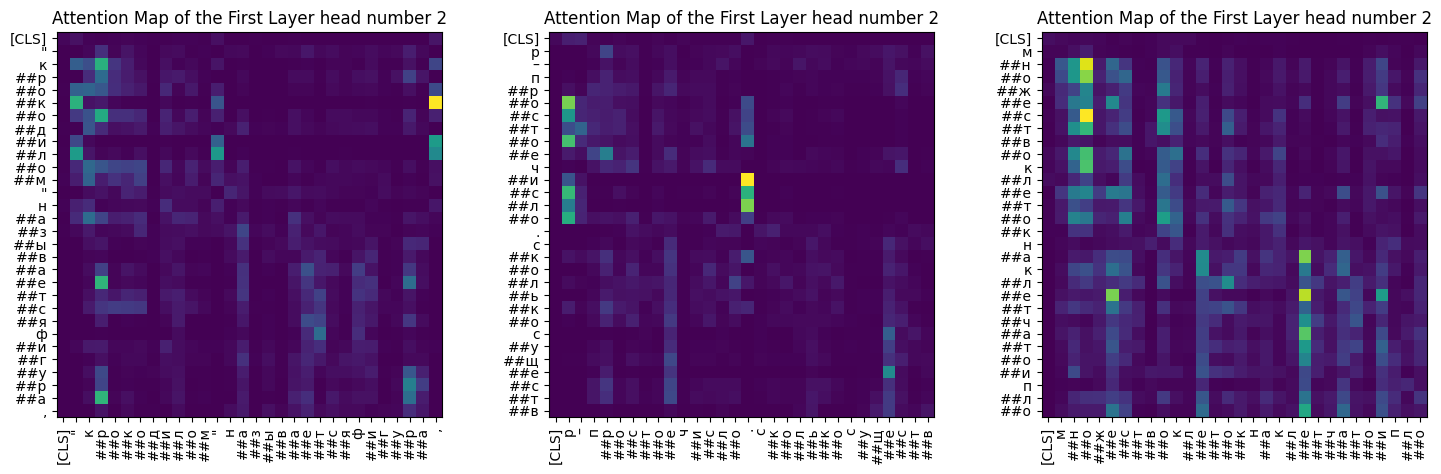

In [ ]:
visualize_attention_map_2(texts=texts2,
                          model=mathbert_freezed,
                          tokenizer=tokenizer2,
                          att_head_number=2,
                          att_slice_from=None,
                          att_slice_to=30)

## mathBert ru full train

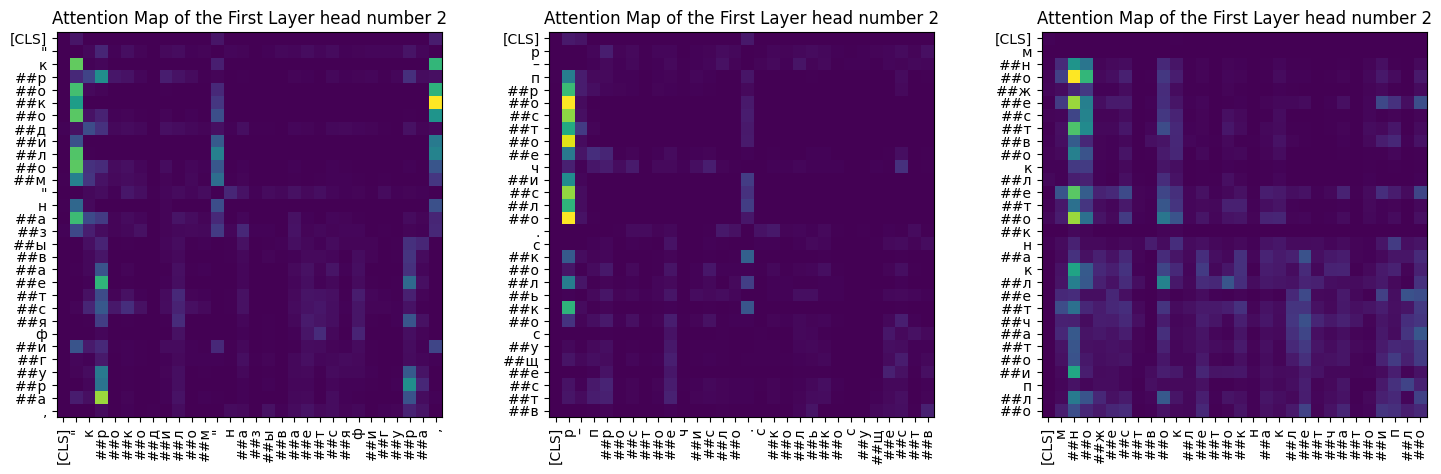

In [ ]:
visualize_attention_map_2(texts=texts2,
                          model=mathbert_full_tuned,
                          tokenizer=tokenizer2,
                          att_head_number=2,
                          att_slice_from=None,
                          att_slice_to=30)

Ну он начинает смотреть на соседние токены, пытаясь сложить из них слова. Но, это не тот путь, который к чему-то хорошему приведет, фактически мы заново тренируем модель с ущербным словарем.

## mathBert EN до обучения

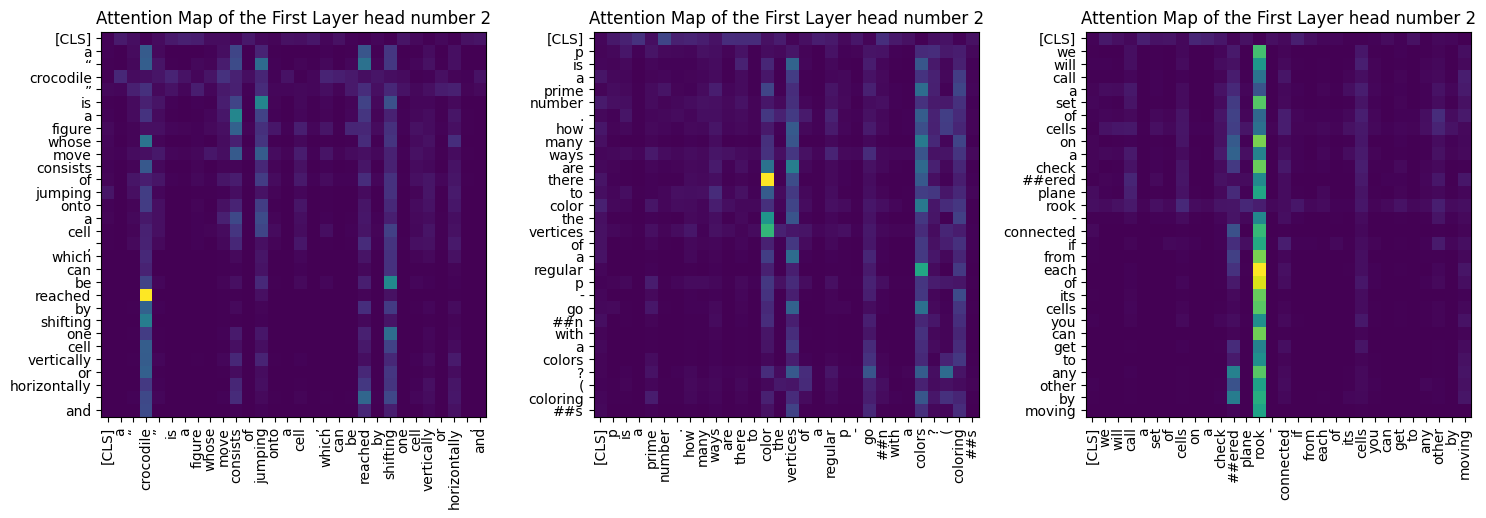

In [ ]:
visualize_attention_map_2(texts=texts3,
                          model=mathbert_en_freezed,
                          tokenizer=tokenizer3,
                          att_head_number=2,
                          att_slice_from=None,
                          att_slice_to=30)

очень неплохо. 'crocodile' <-> 'reached', 'color' <->'there, vertives', 'rook' <-> 'from each'

## mathBert EN full train

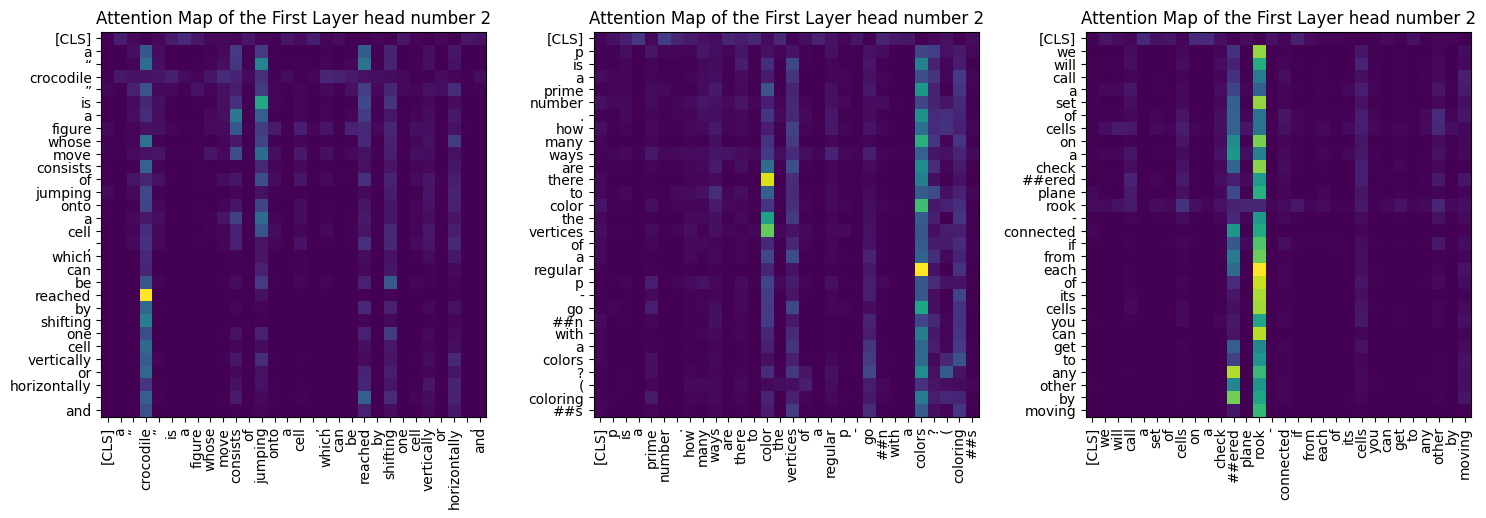

In [ ]:
visualize_attention_map_2(texts=texts3,
                          model=mathbert_en_full_tuned,
                          tokenizer=tokenizer3,
                          att_head_number=2,
                          att_slice_from=None,
                          att_slice_to=30)

Обучение немного услило связи с теми же словами. Но, поскольку свзяи изначально были "правильными", то изменение малозаметно

### **ВЫВОД**
- дообучение с использованием backbone заметно повышает метрики, но при этом растет риск переобучения
- при замороженном backbone внимание не меняется (т.к. это часть backbone)
- при дообучении (полном) модель учится связывать между собой ключевые слова
- модель, обученная на английских текстах неважно работает с русскими. Но работает.

# finish

# ATERNATIVE TRAIN LOOP
в целом тоже работало на каком-то этапе, но используется свой трейнер, оставлено для истории

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
def compute_metrics(eval_preds):
    # print(list(eval_preds))
    logits, labels = eval_preds
    # logits, labels = a
    predictions = sigmoid(logits) > 0.5
    emr = compute_exact_match_ratio(predictions, labels)
    return {"exact_match_ratio": emr}

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def compute_exact_match_ratio(preds, labels):
    """
    Функция для расчета Exact Match Ratio (EMR).
    :param preds: предсказанные значения
    :param labels: истинные значения
    :return: значение EMR
    """
    # print(preds)
    # print(labels)
    assert len(preds) == len(labels), "Predictions and labels must have the same length"
    exact_matches = sum(np.all(p == l) for p, l in zip(preds, labels))
    return exact_matches / labels.shape[0]

In [ ]:
def train_transformer(transformer_model, ds, model_name='cointegrated/rubert-tiny2', exp_name='test', freeze_backbone=True):
    model = copy.deepcopy(transformer_model)
    model.full_output=False
    if freeze_backbone:
        model = freeze_backbone_function(model)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    training_args = TrainingArguments(
    output_dir=exp_name,
    learning_rate=2e-3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=100,
    )

    trainer = Trainer(
    model=model_frozen,
    args=training_args,
    train_dataset=ds_s["train"],
    eval_dataset=ds_s["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    )
    trainer.train()
    return model

In [ ]:
dss=ds.train_test_split(test_size=0.2)
ft_model=train_transformer(model, dss)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 

dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)

  warnings.warn(


In [ ]:
model=TransformerClassificationModel('cointegrated/rubert-tiny2', num_labels=7 )
dss=ds.train_test_split(test_size=0.2)
ft_model_unfreeezed=train_transformer(model, dss,exp_name='test2', freeze_backbone=False)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 

dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)

  warnings.warn(


3 слоя трансформера, скрытое сосстояние  размерностью 312, 12 голов внимания.